In [1]:
library(Seurat)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [2]:
folder_path <- "/data2/ZenNa/DFU_Project/Data/SubSet_DFU-Healer_DFU-Non healer"
csv_files <- list.files(path = folder_path, pattern = "\\.csv$", full.names = TRUE)

In [3]:
# Init seurat object list
seurat_object_list <- list()

In [5]:
for (csv_file in csv_files) {
  # Read the CSV file into a data frame
  dataset <- read.csv(csv_file)
  
  # Extract the sample name from the file name
  sample_name <- tools::file_path_sans_ext(basename(csv_file))
  
  # Create a Seurat object from the data frame
  seurat_obj <- CreateSeuratObject(counts = dataset, project = sample_name, min.cells = 3, min.features = 200)
  
  # Subset the Seurat object based on specific criteria
   seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")

  seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 50)
  
  # Store the Seurat object in the list using the sample name as the key
  seurat_object_list[[sample_name]] <- seurat_obj
}

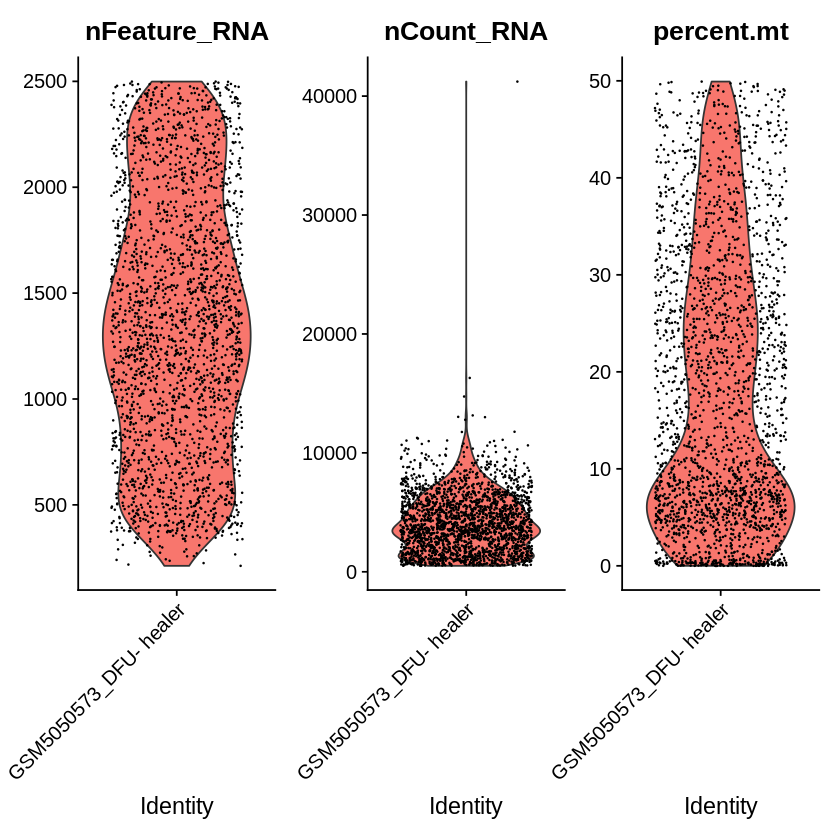

In [6]:
VlnPlot(seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [7]:
DFU_data.list <- seurat_object_list

In [8]:
DFU_data.list <- lapply(X = DFU_data.list, FUN = function(x) {
    x <- NormalizeData(x, verbose = FALSE)
    x <- FindVariableFeatures(x, verbose = FALSE)
})

# Next, select features for downstream integration, and run PCA on each object in the list, which is required for running the alternative reciprocal PCA workflow.

In [9]:
features <- SelectIntegrationFeatures(object.list = DFU_data.list)
DFU_data.list <- lapply(X = DFU_data.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
})

In [10]:
anchors <- FindIntegrationAnchors(object.list = DFU_data.list, reference = c(1, 2), reduction = "rpca",
    dims = 1:50)
DFU_data.integrated <- IntegrateData(anchorset = anchors, dims = 1:50)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Computing 2000 integration features

Scaling features for provided objects

Computing within dataset neighborhoods

Finding anchors between all query and reference datasets

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1657 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1488 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1317 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1343 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1327 anchors

Projecting new data onto SVD

Projecting new data ont

In [11]:
DFU_data.integrated <- ScaleData(DFU_data.integrated, verbose = FALSE)
DFU_data.integrated <- RunPCA(DFU_data.integrated, verbose = FALSE)
DFU_data.integrated <- RunUMAP(DFU_data.integrated, dims = 1:50)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:10:17 UMAP embedding parameters a = 0.9922 b = 1.112

15:10:17 Read 29319 rows and found 50 numeric columns

15:10:17 Using Annoy for neighbor search, n_neighbors = 30

15:10:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:10:19 Writing NN index file to temp file /tmp/RtmpDJOkxB/file19e9b974f088bc

15:10:19 Searching Annoy index using 1 thread, search_k = 3000

15:10:26 Annoy recall = 100%

15:10:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

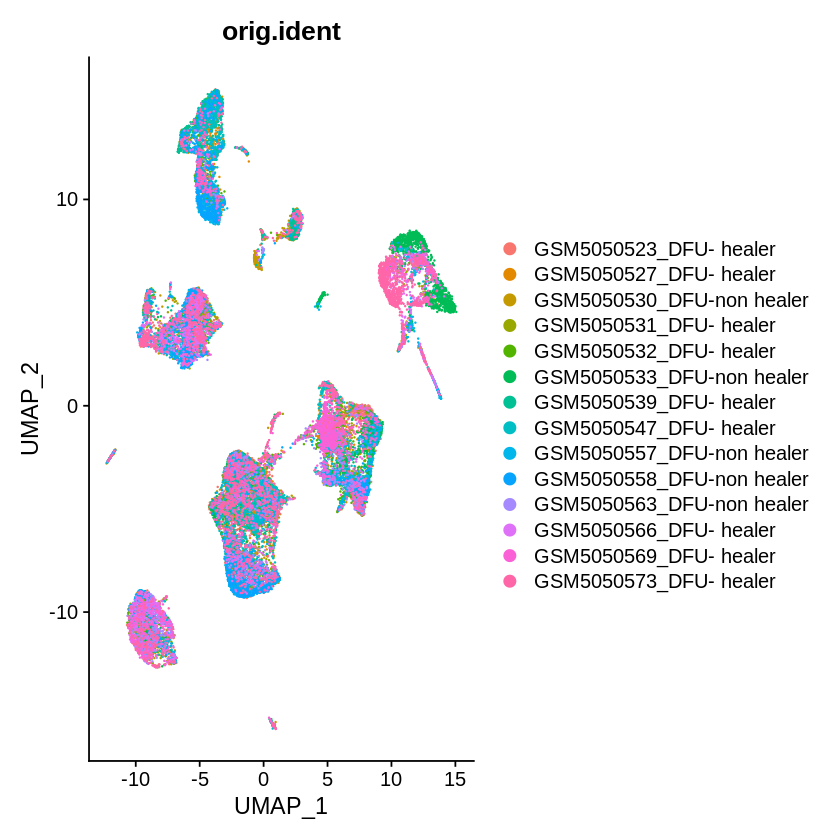

In [12]:
DimPlot(DFU_data.integrated, group.by = "orig.ident")

In [ ]:
# Split groups

In [18]:
# Create a new metadata column to group samples
DFU_data.integrated$major_group <- ifelse(grepl("_DFU-non healer$", DFU_data.integrated$orig.ident), "DFU-non healer", "DFU- healer")

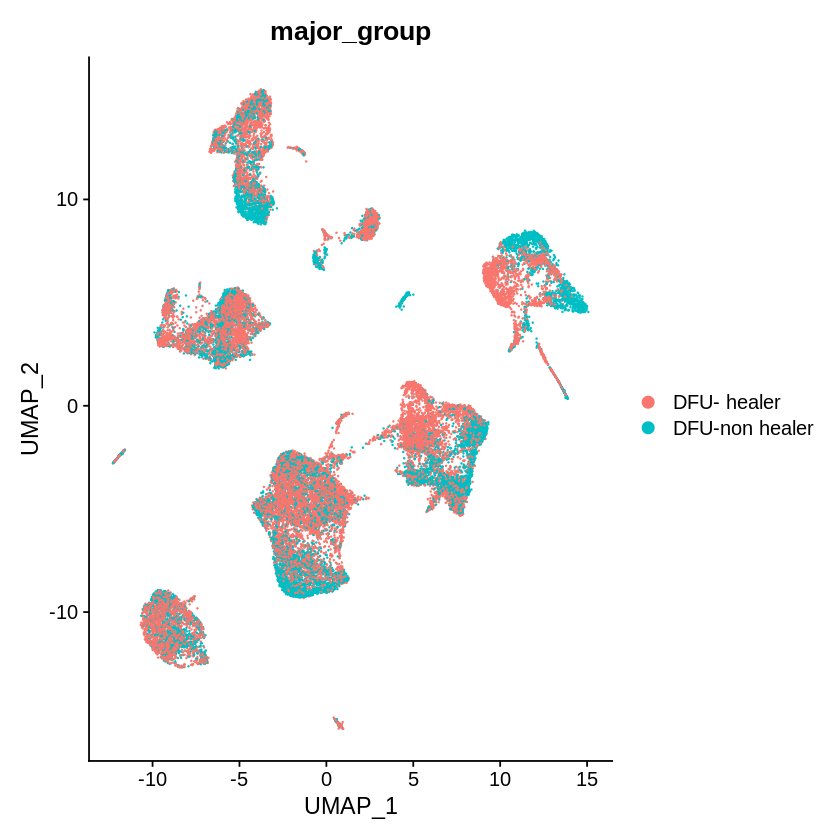

In [19]:
# Plot based on the major_group column
DimPlot(DFU_data.integrated, group.by = "major_group")

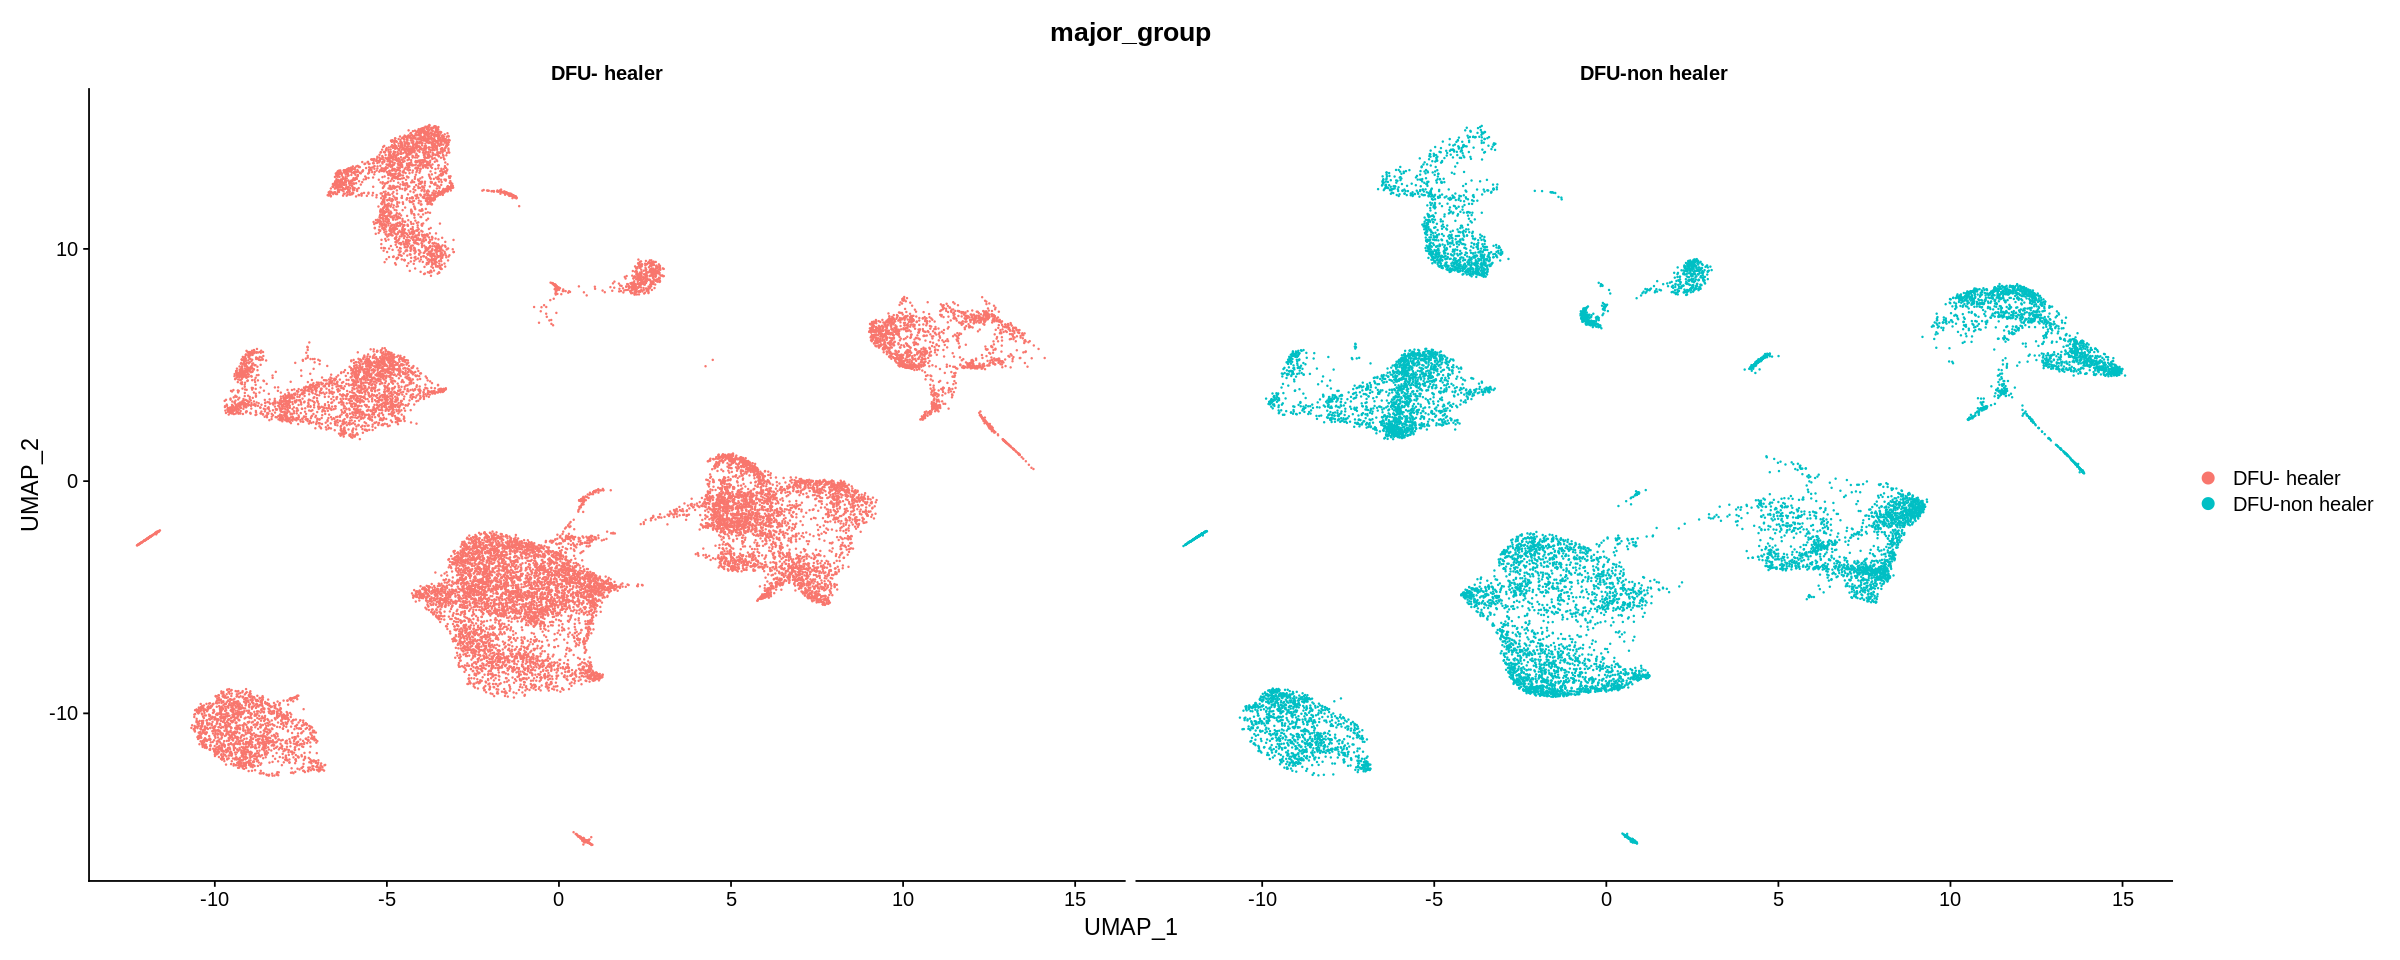

In [27]:
# Set the size of the UMAP plots
options(repr.plot.width = 20, repr.plot.height = 8)
# Create separate UMAP plots for each major group
DimPlot(DFU_data.integrated, group.by = "major_group", split.by = "major_group")

In [28]:
DFU_data.integrated <- FindNeighbors(DFU_data.integrated, dims = 1:50)


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29319
Number of edges: 1167587

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9935
Number of communities: 9
Elapsed time: 3 seconds


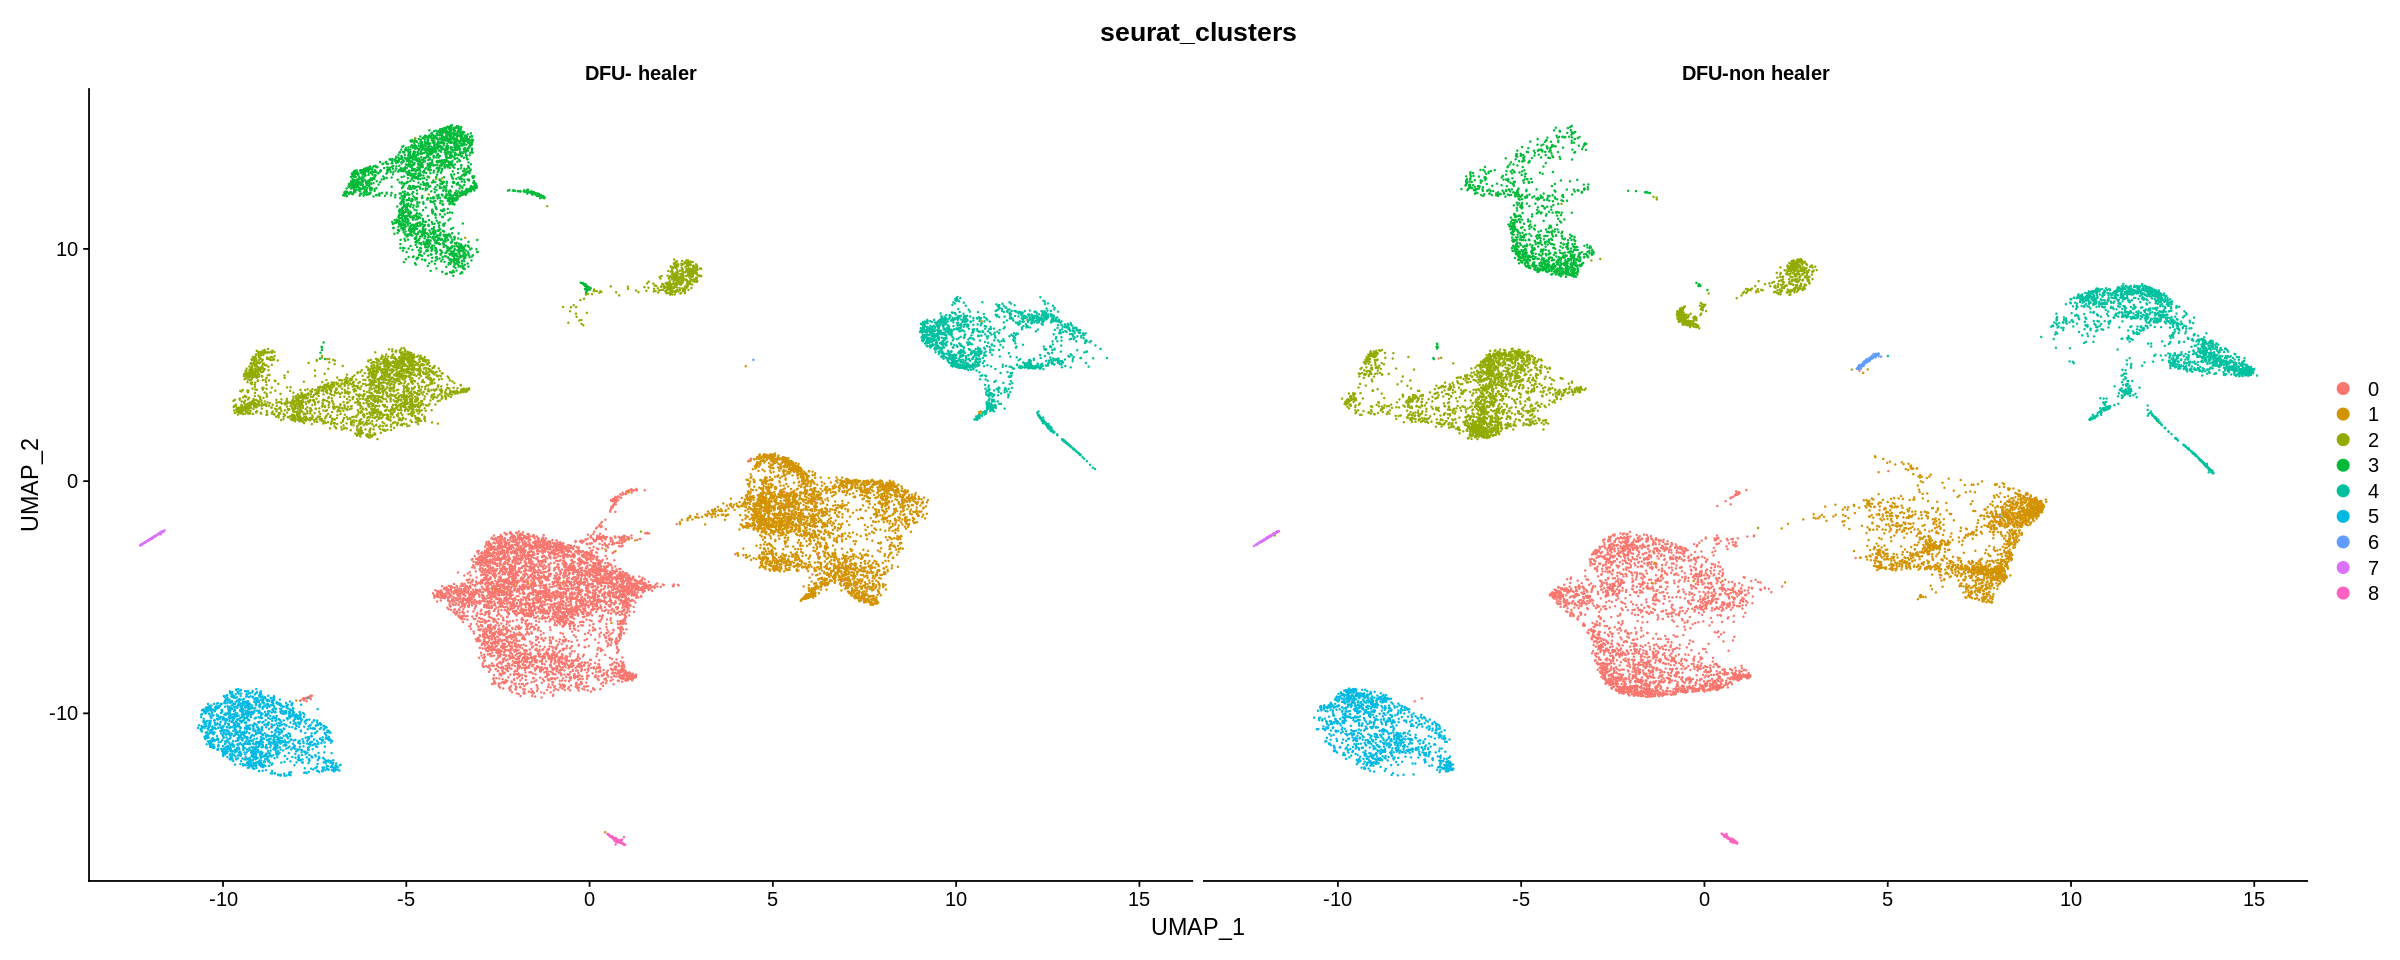

In [29]:
options(repr.plot.width = 20, repr.plot.height = 8)
DFU_data.integrated <- FindClusters(DFU_data.integrated, resolution = 0.02)  # can adjust the resolution parameter
DimPlot(DFU_data.integrated, group.by = 'seurat_clusters', split.by = "major_group")

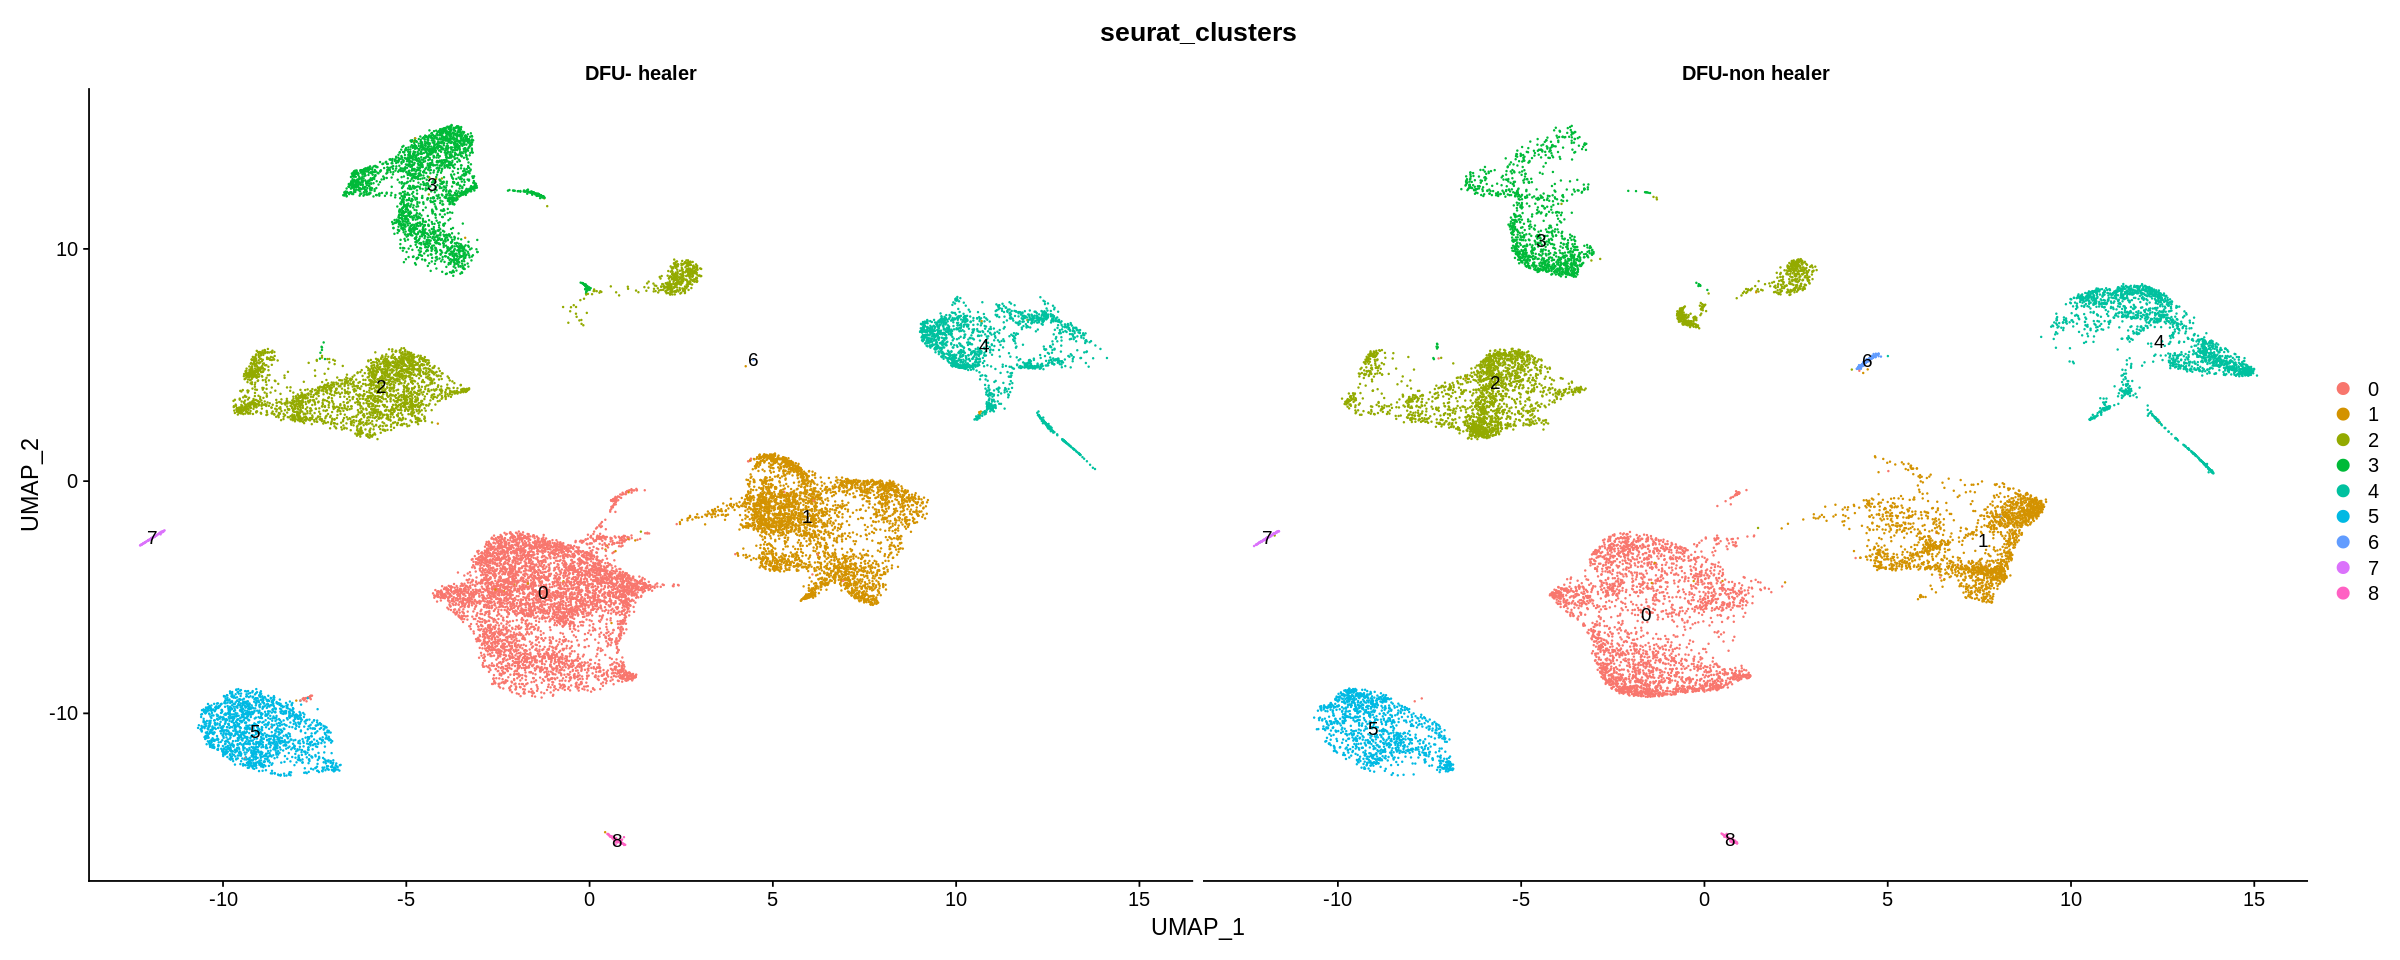

In [30]:
DimPlot(DFU_data.integrated, 
        group.by = 'seurat_clusters', 
        split.by = "major_group", 
        label = TRUE) # Add labels to clusters

In [33]:
install.packages('BiocManager')
BiocManager::install('limma')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.22), R 4.2.3 (2023-03-15)

Installing package(s) 'limma'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'knitr', 'RcppArmadillo', 'reticulate', 'spatstat.random'



In [34]:
library(limma)

In [35]:
all.markers <- FindAllMarkers(object = DFU_data.integrated)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: CD206”


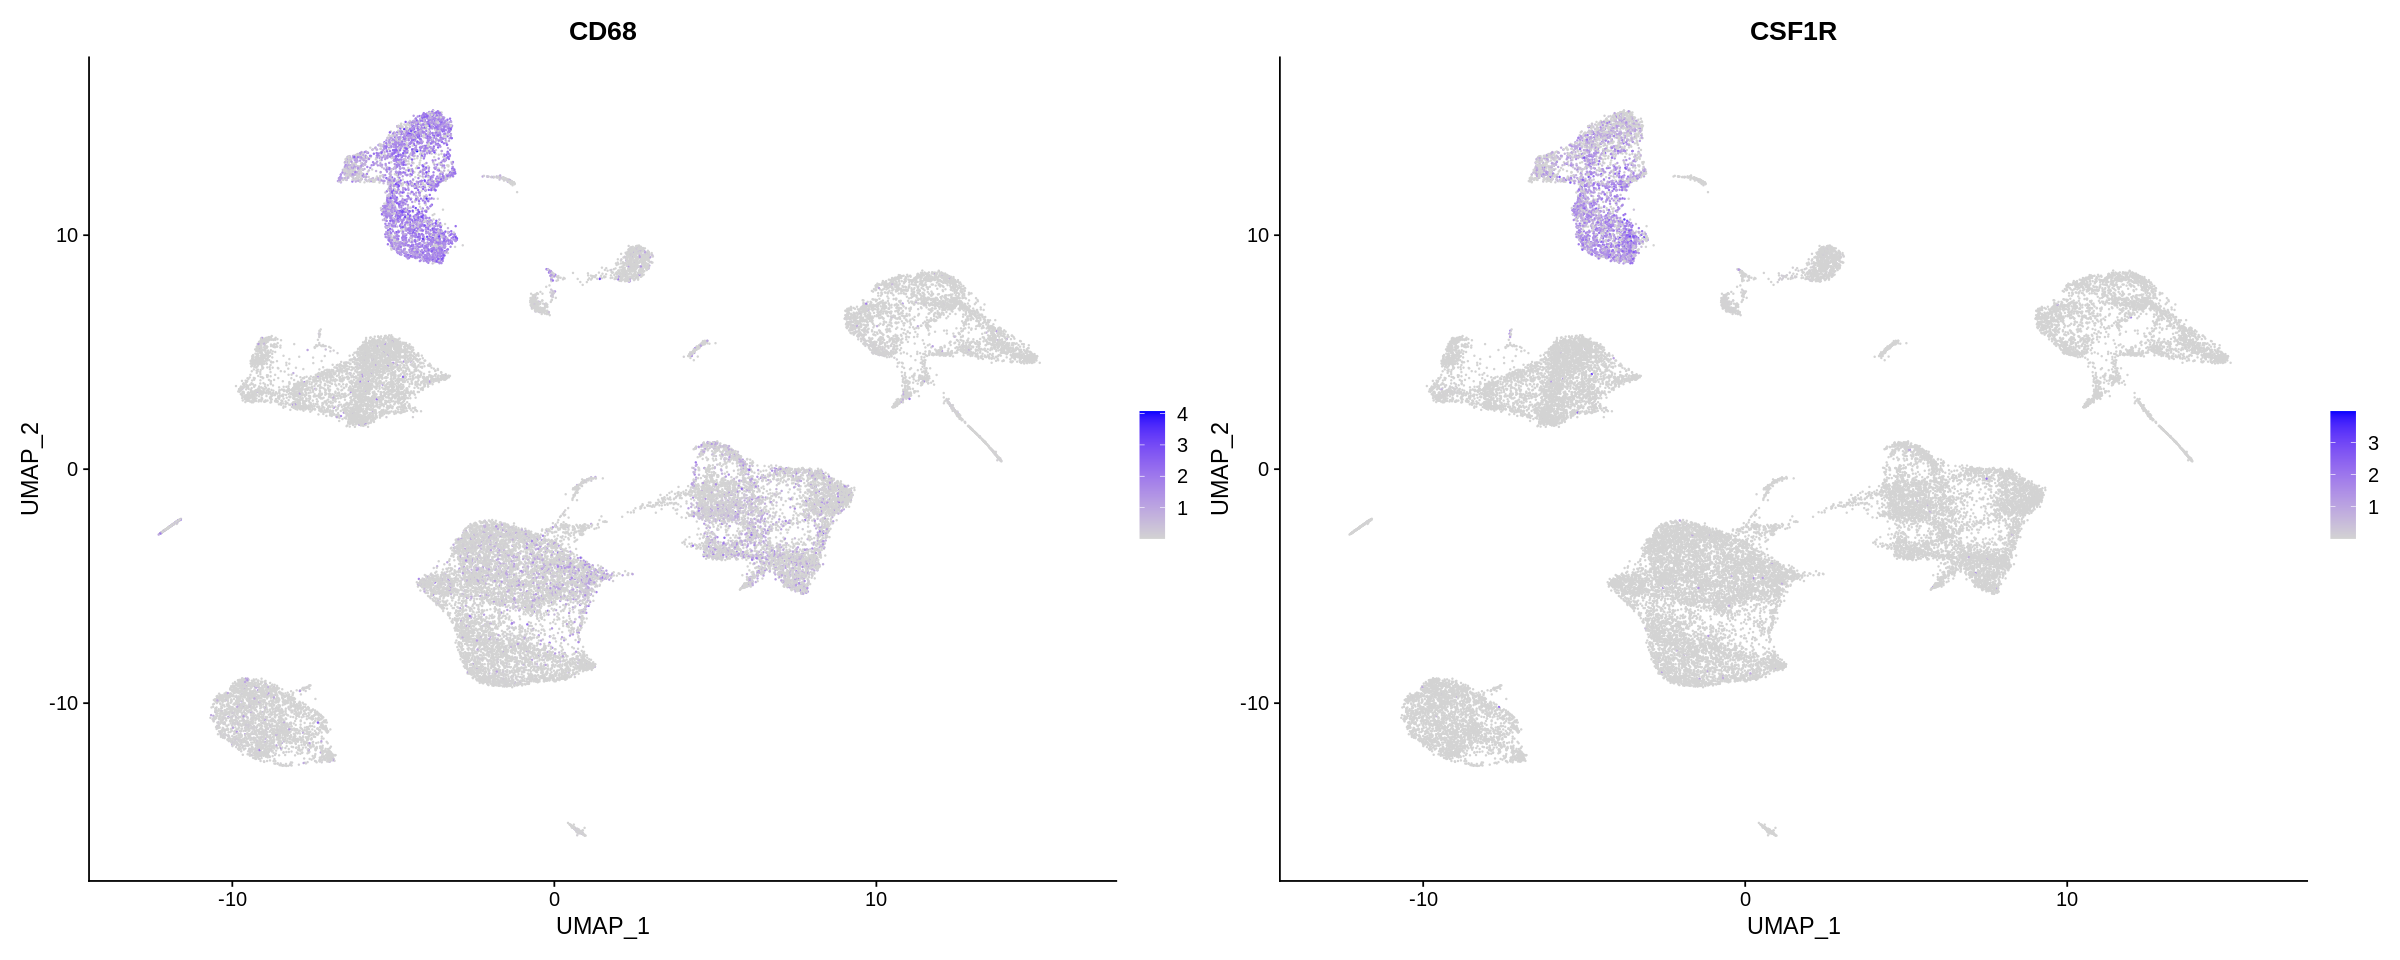

In [39]:
FeaturePlot(DFU_data.integrated, features = c('CD68', 'CSF1R', 'CD206'), min.cutoff = "q9") #macrophage 3

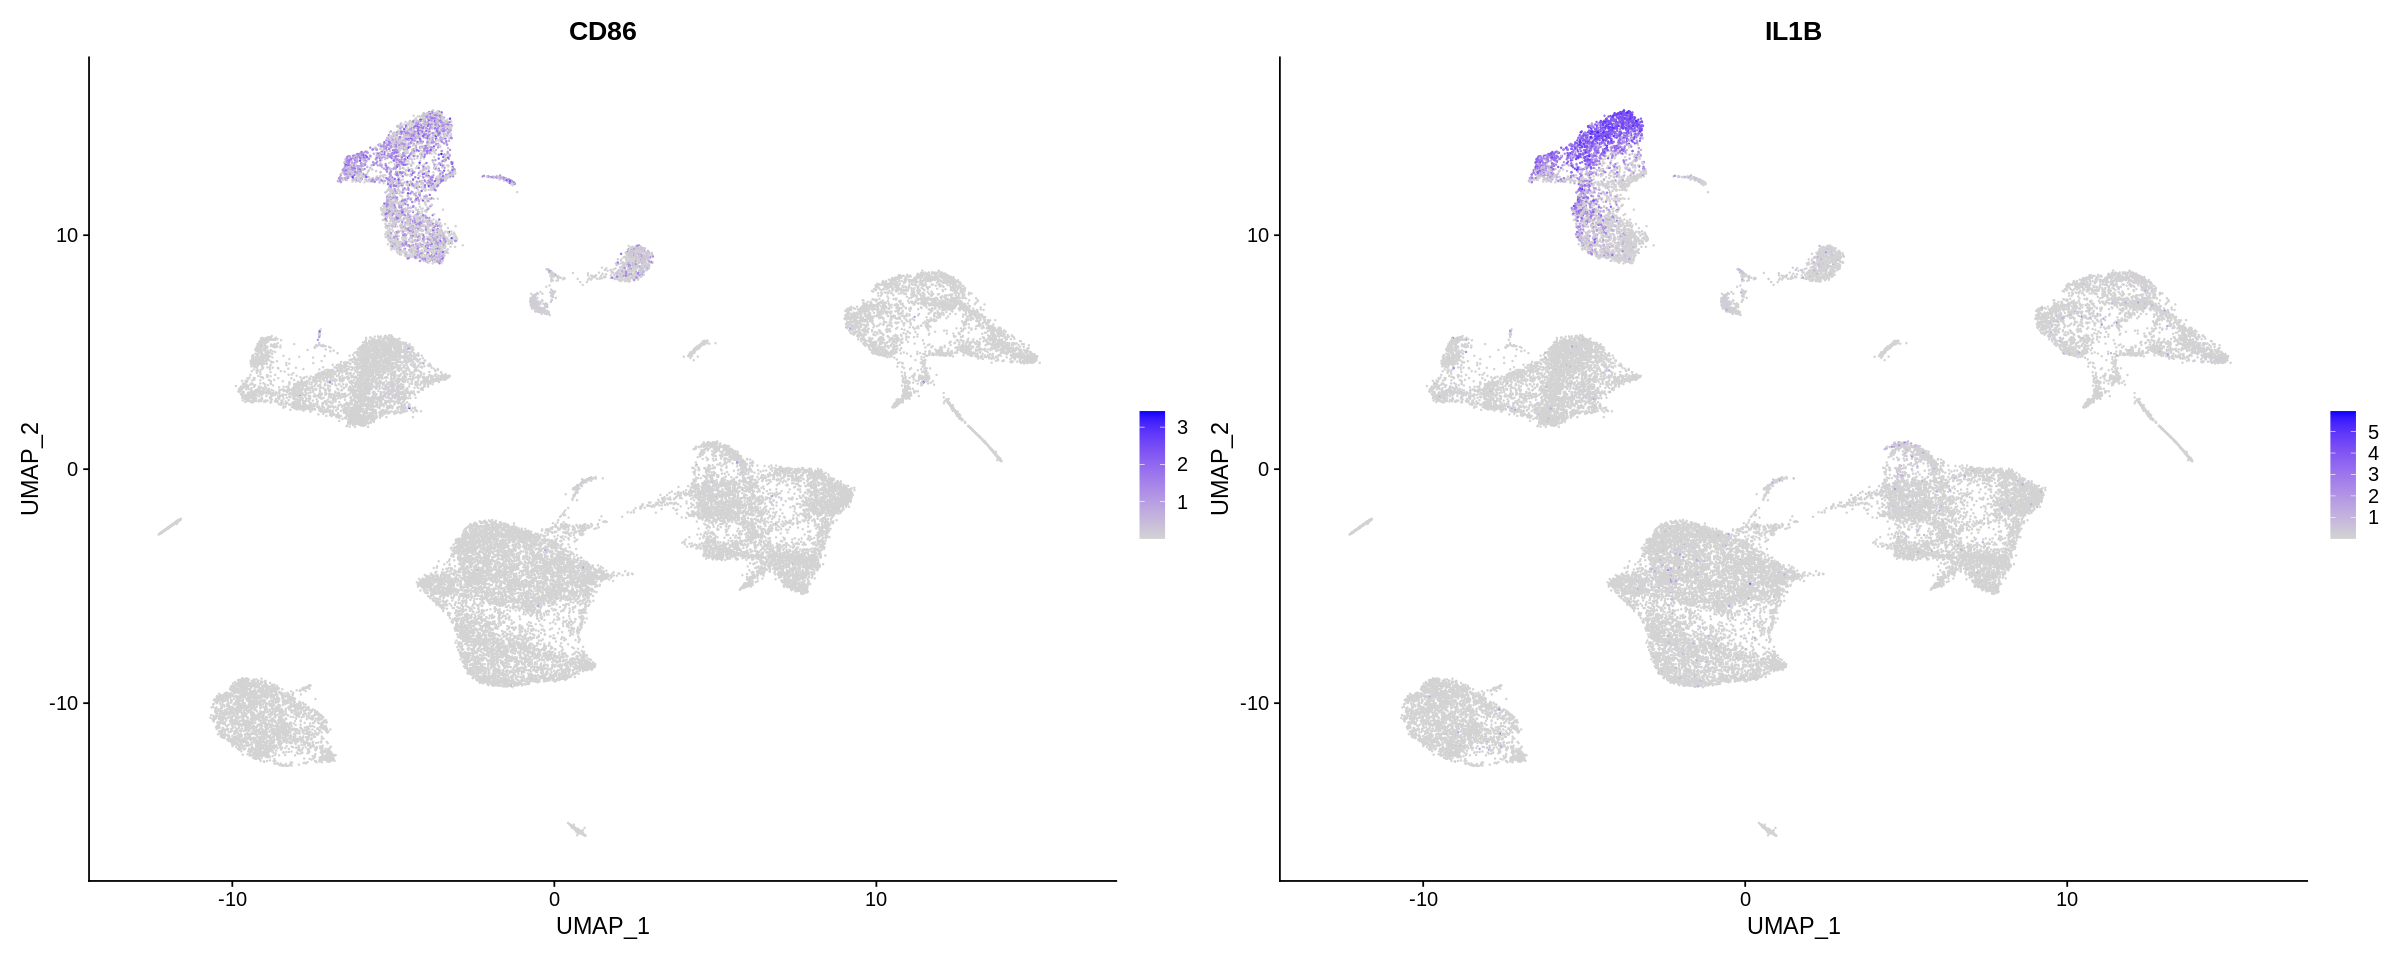

In [38]:
FeaturePlot(DFU_data.integrated, features = c('CD86', 'IL1B'), min.cutoff = "q9")

Warning message:
“Could not find MS4A1 in the default search locations, found in RNA assay instead”


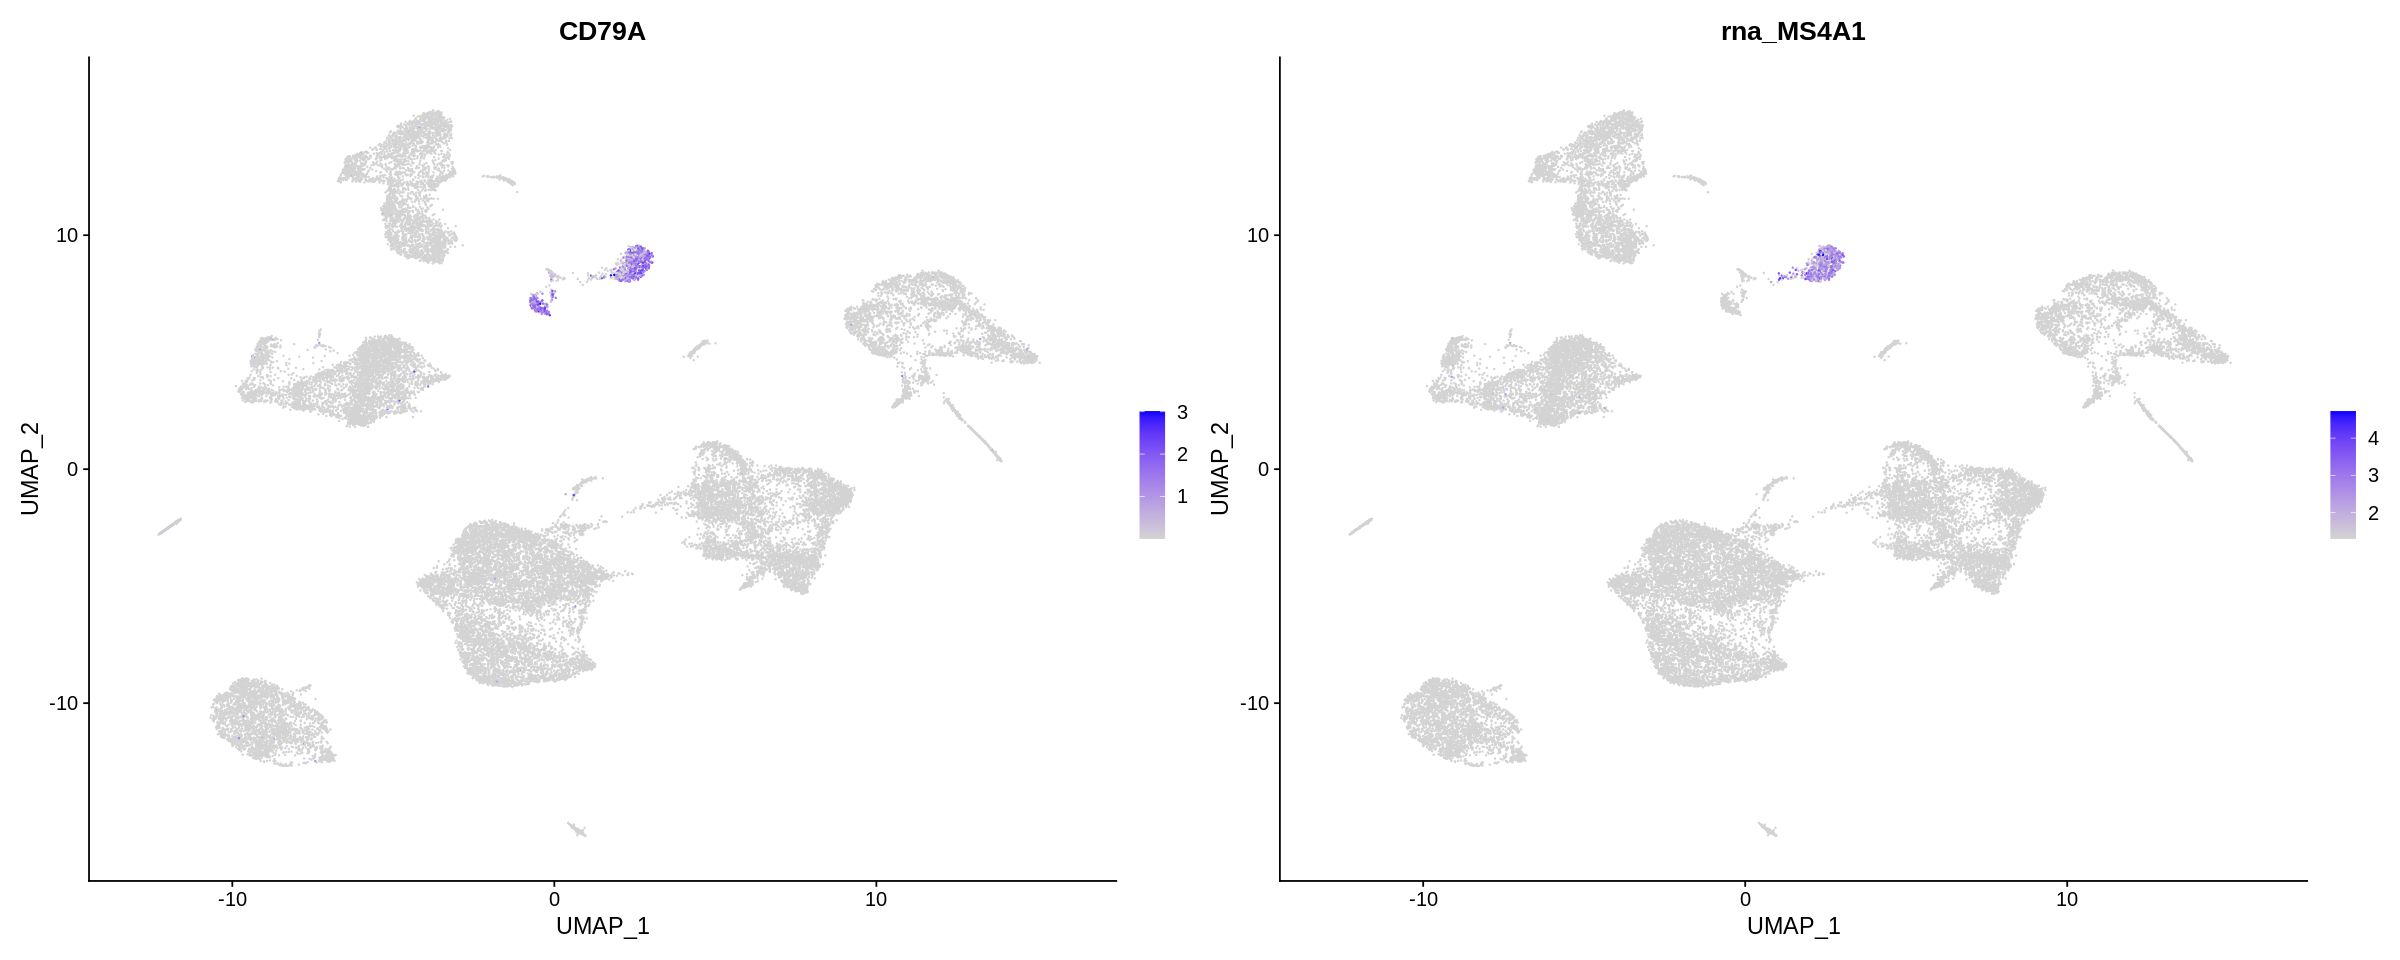

In [40]:
FeaturePlot(DFU_data.integrated, features = c('CD79A', 'MS4A1'), min.cutoff = "q9") #b cell 2

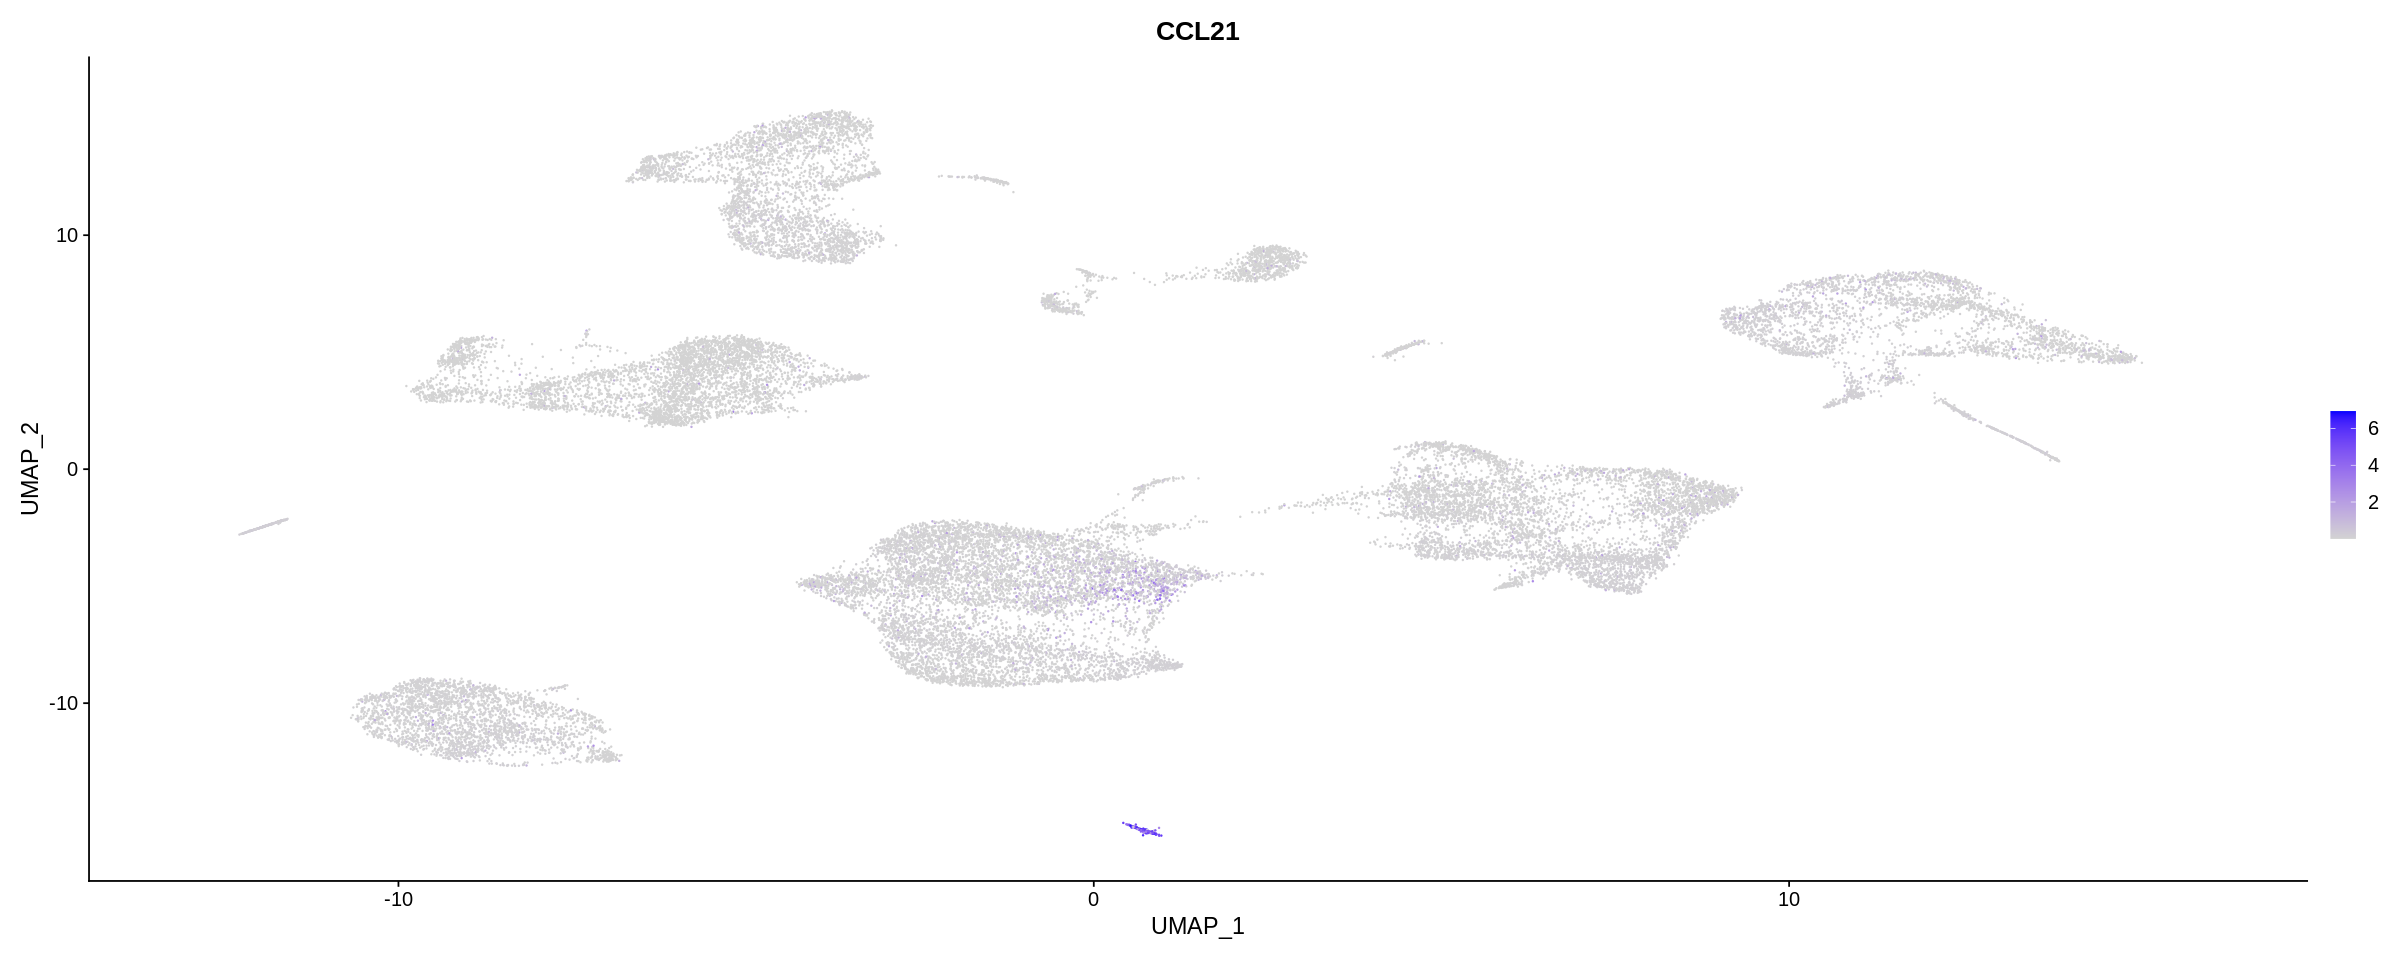

In [41]:
FeaturePlot(DFU_data.integrated, features = c('CCL21'),min.cutoff = "q9") #LymphEndo 8

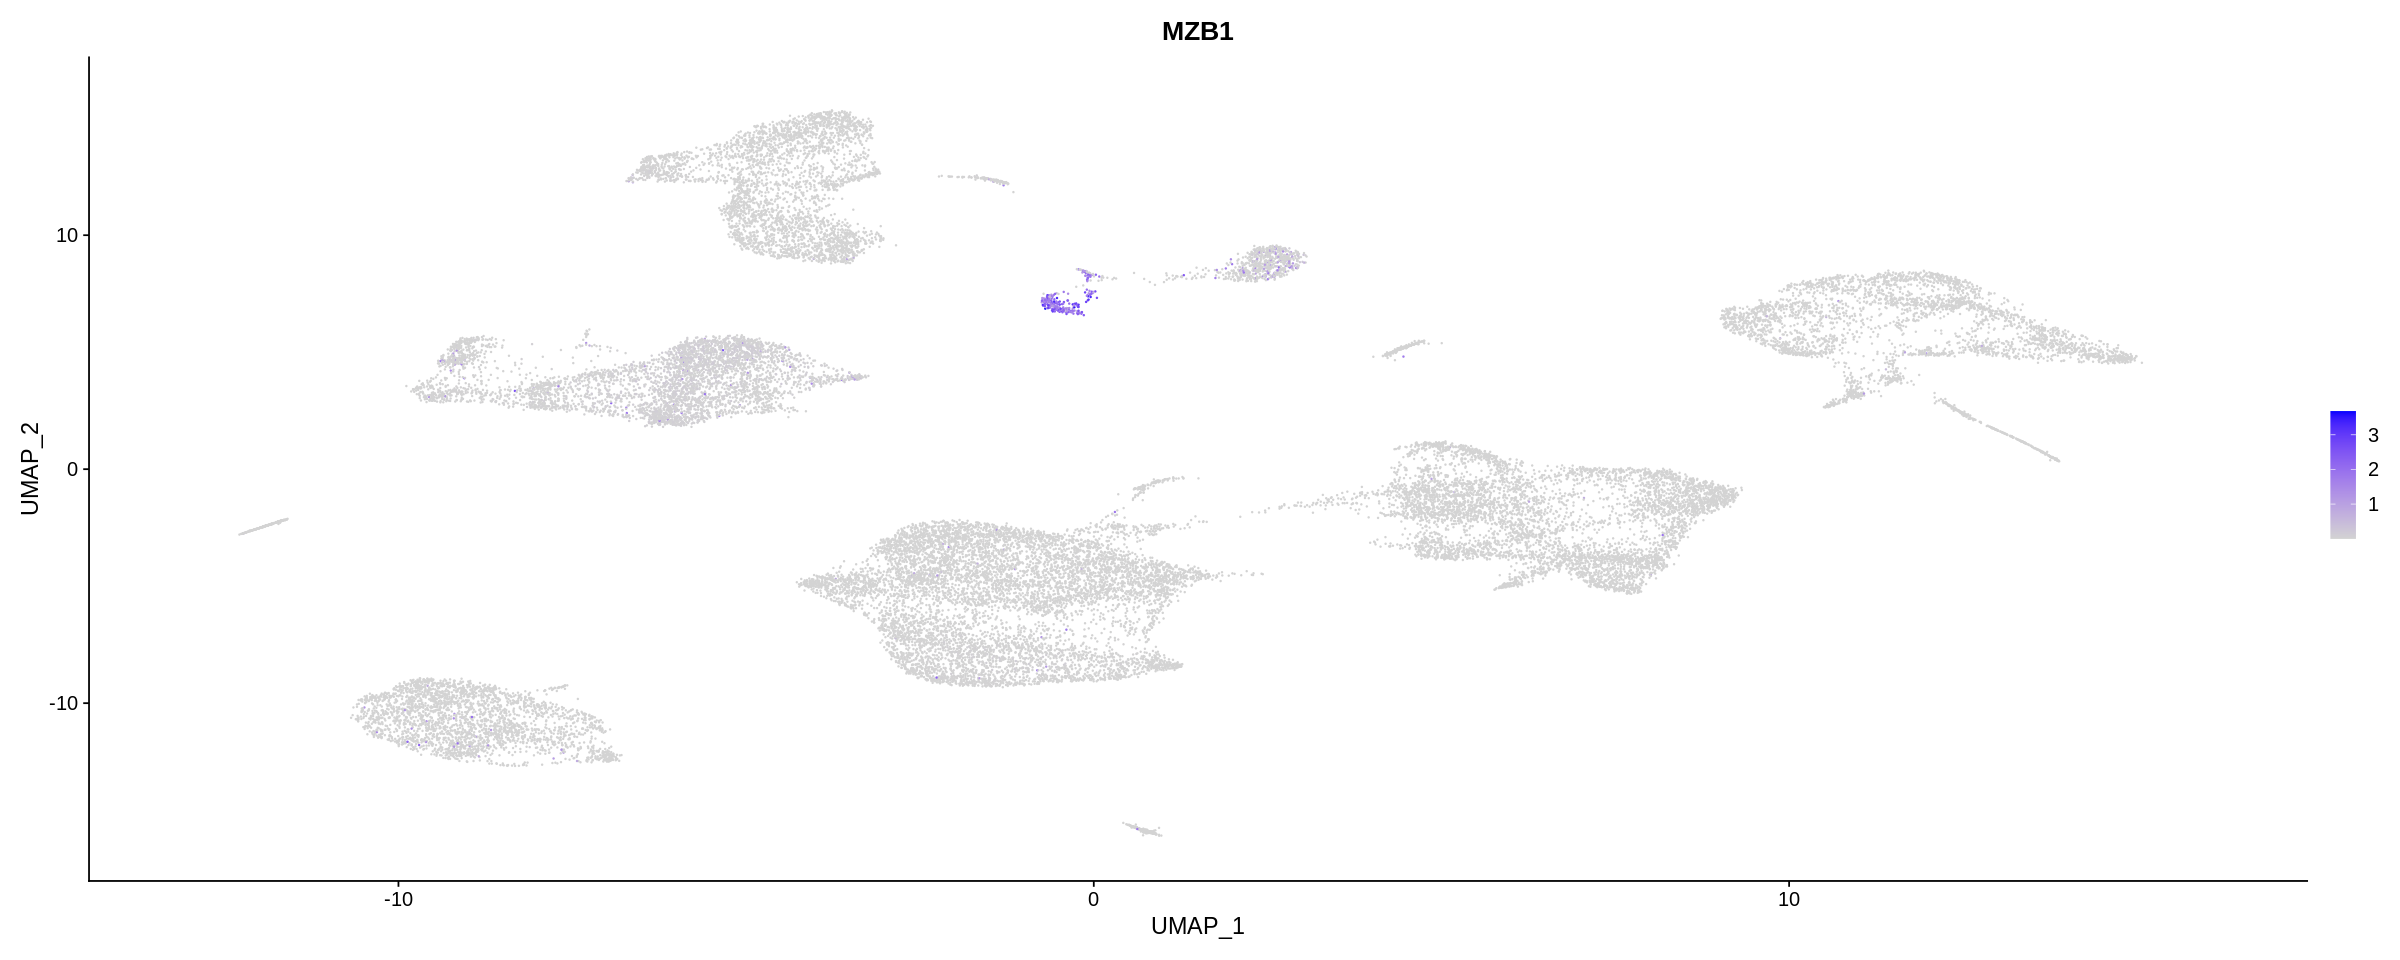

In [42]:
FeaturePlot(DFU_data.integrated, features = c('MZB1'),min.cutoff = "q9") 2

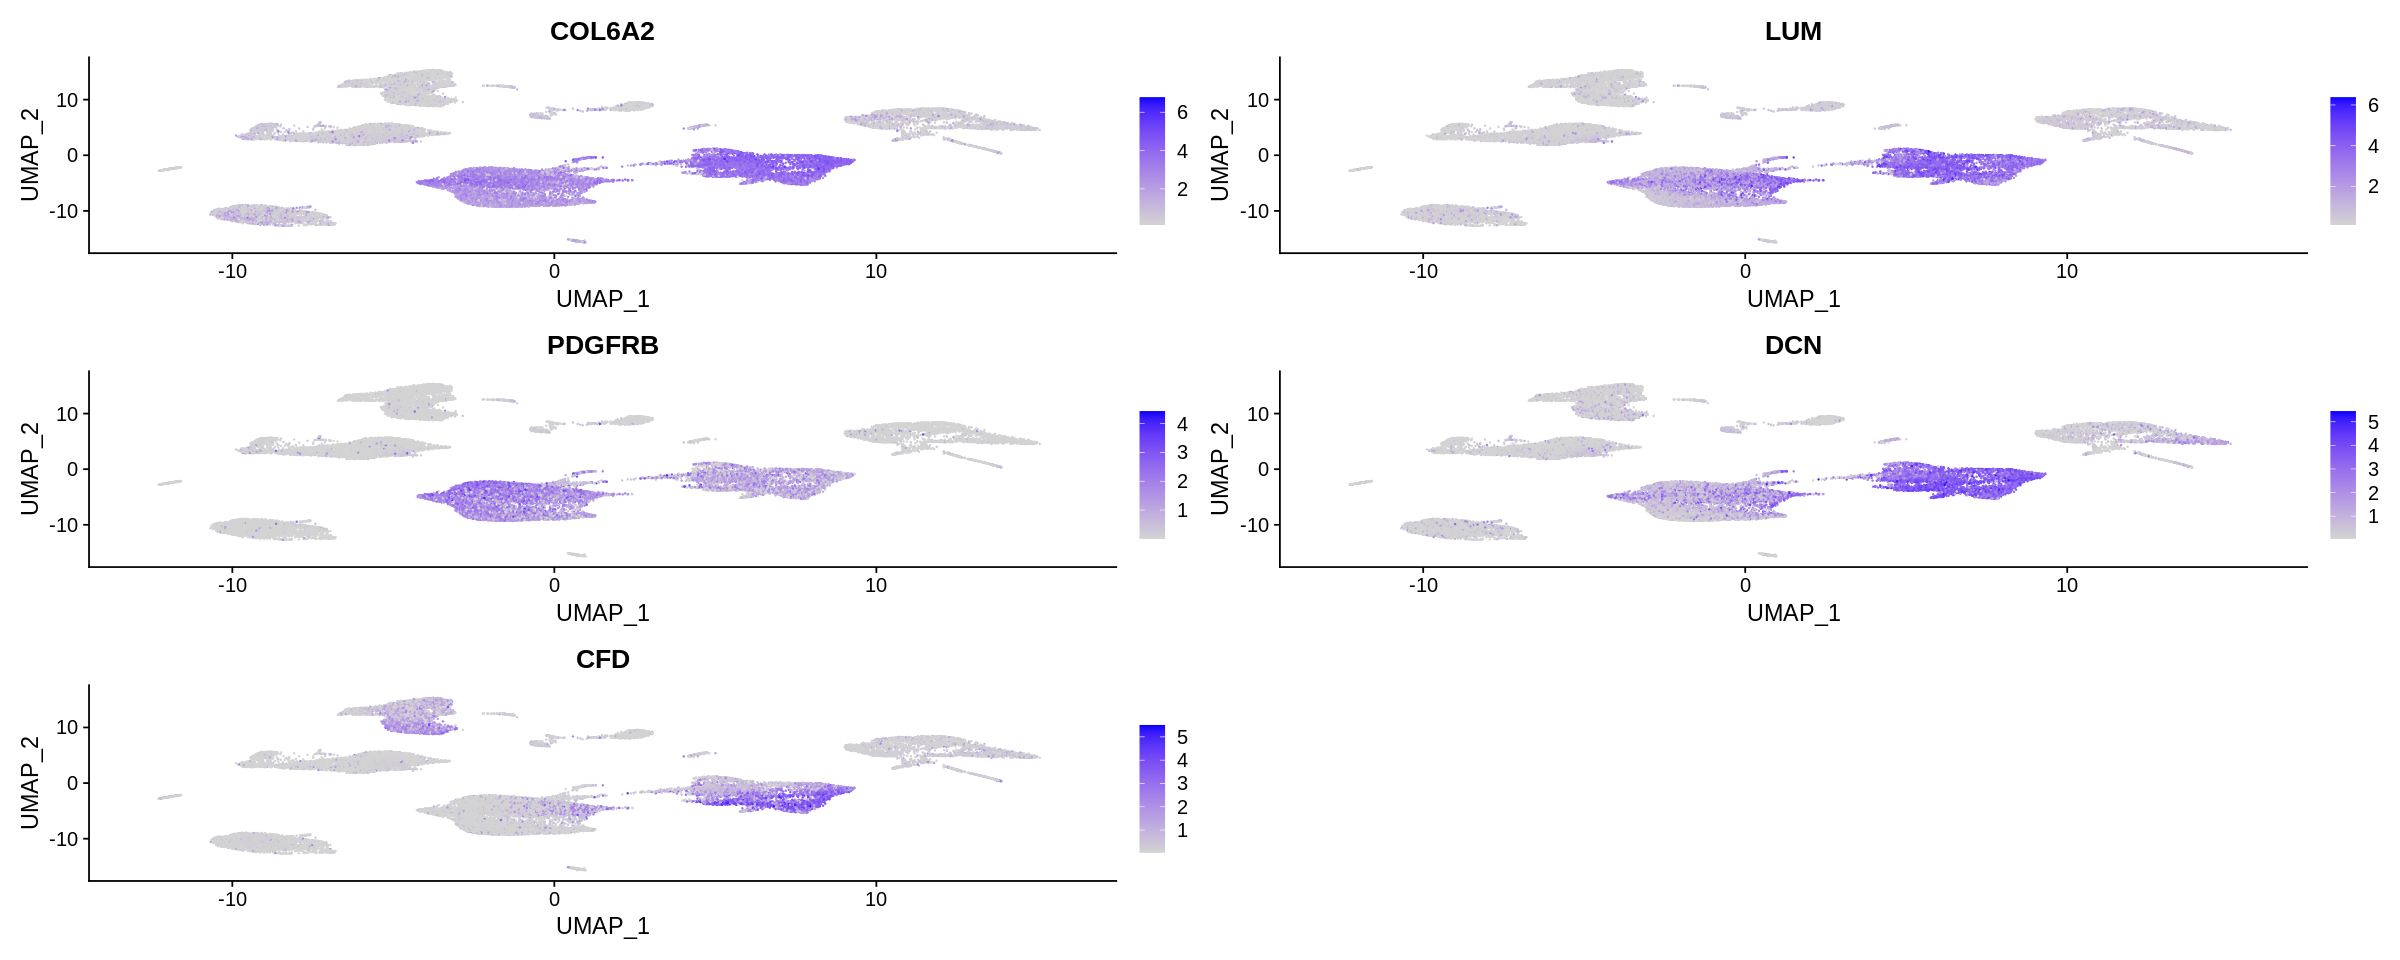

In [43]:
FeaturePlot(DFU_data.integrated, features = c('COL6A2', 'LUM','PDGFRB','DCN','CFD'), min.cutoff = "q9") #Fibroblast 1

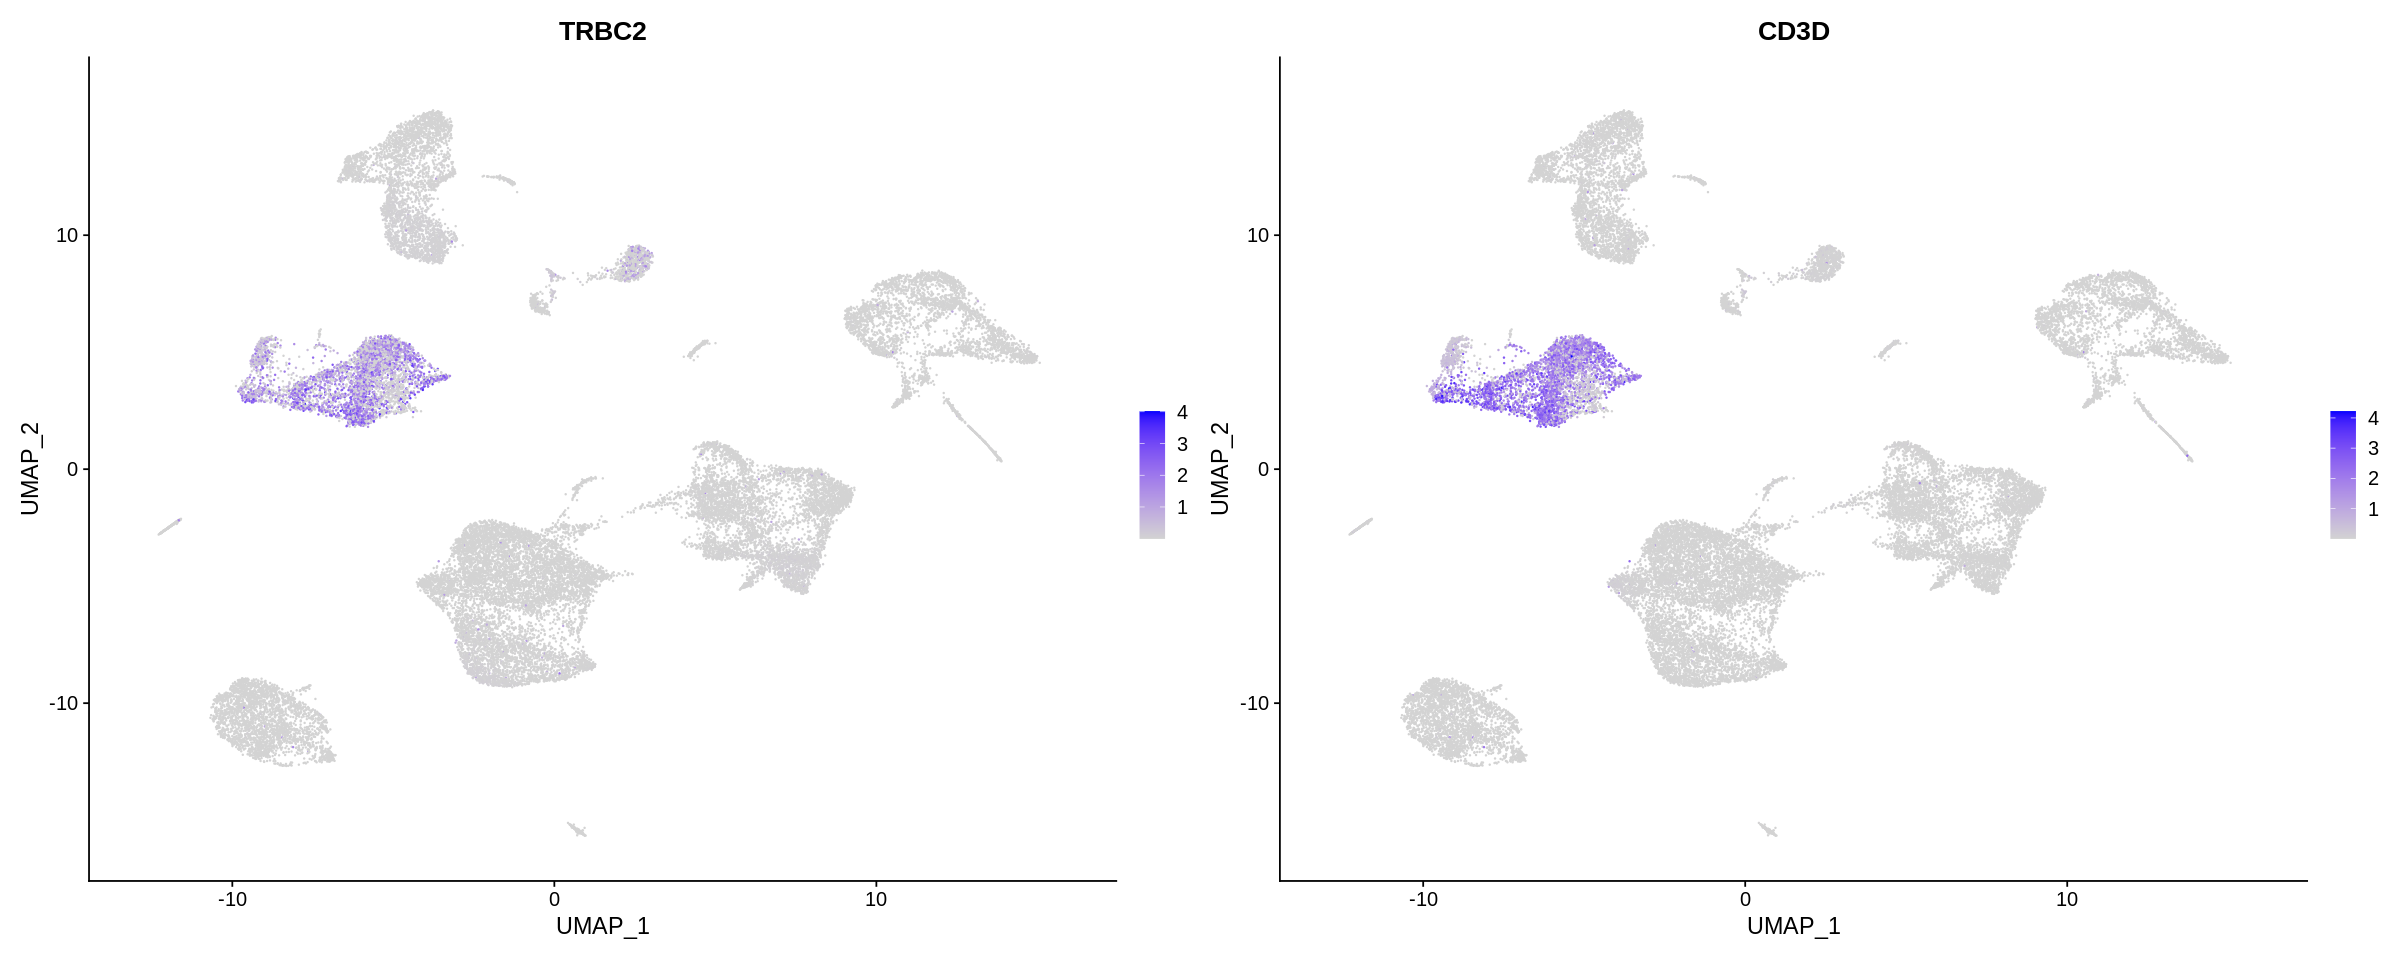

In [44]:
FeaturePlot(DFU_data.integrated, features = c('TRBC2', 'CD3D'), min.cutoff = "q9") #Tcell 2

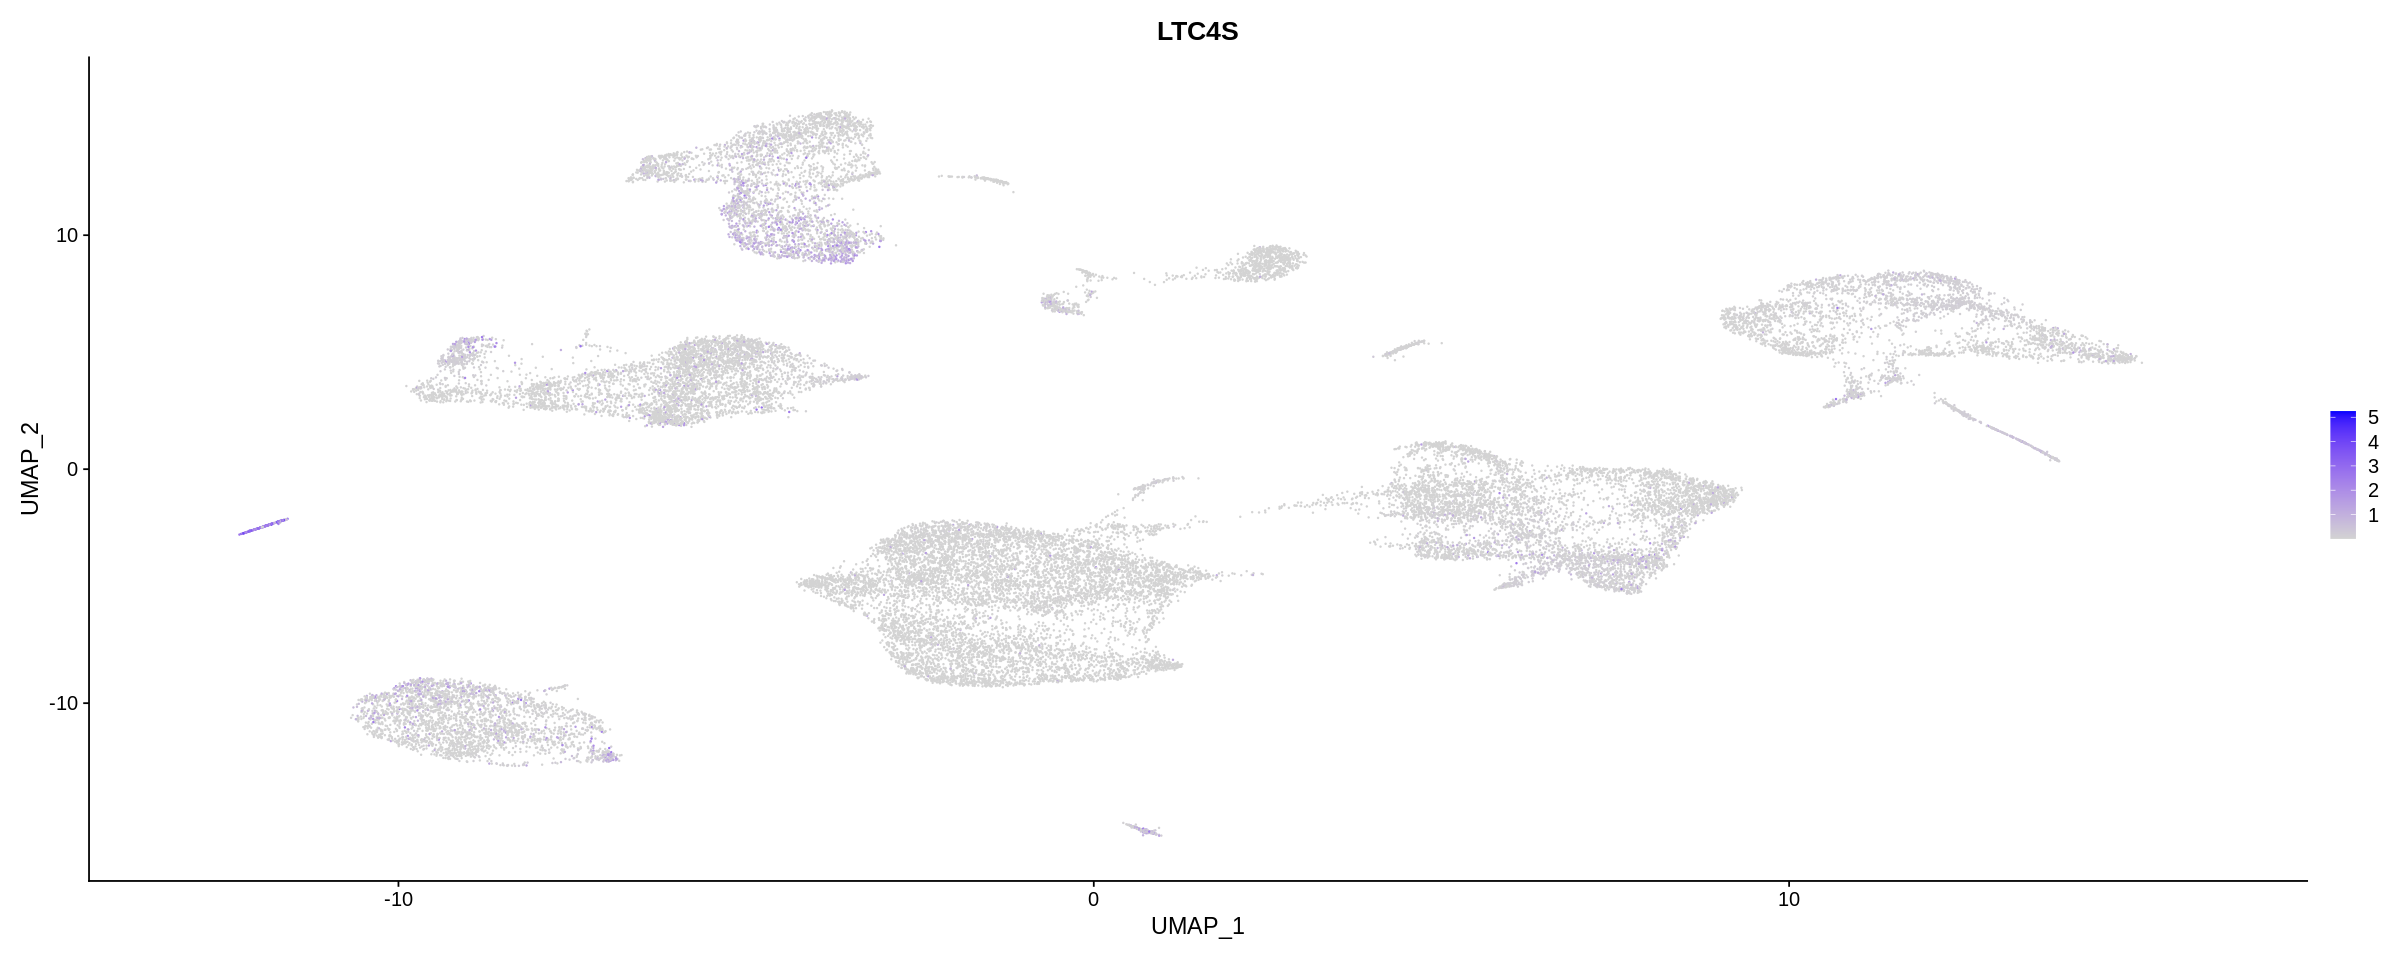

In [45]:
FeaturePlot(DFU_data.integrated, features = c('LTC4S'), min.cutoff = "q9") #Mast cell 7

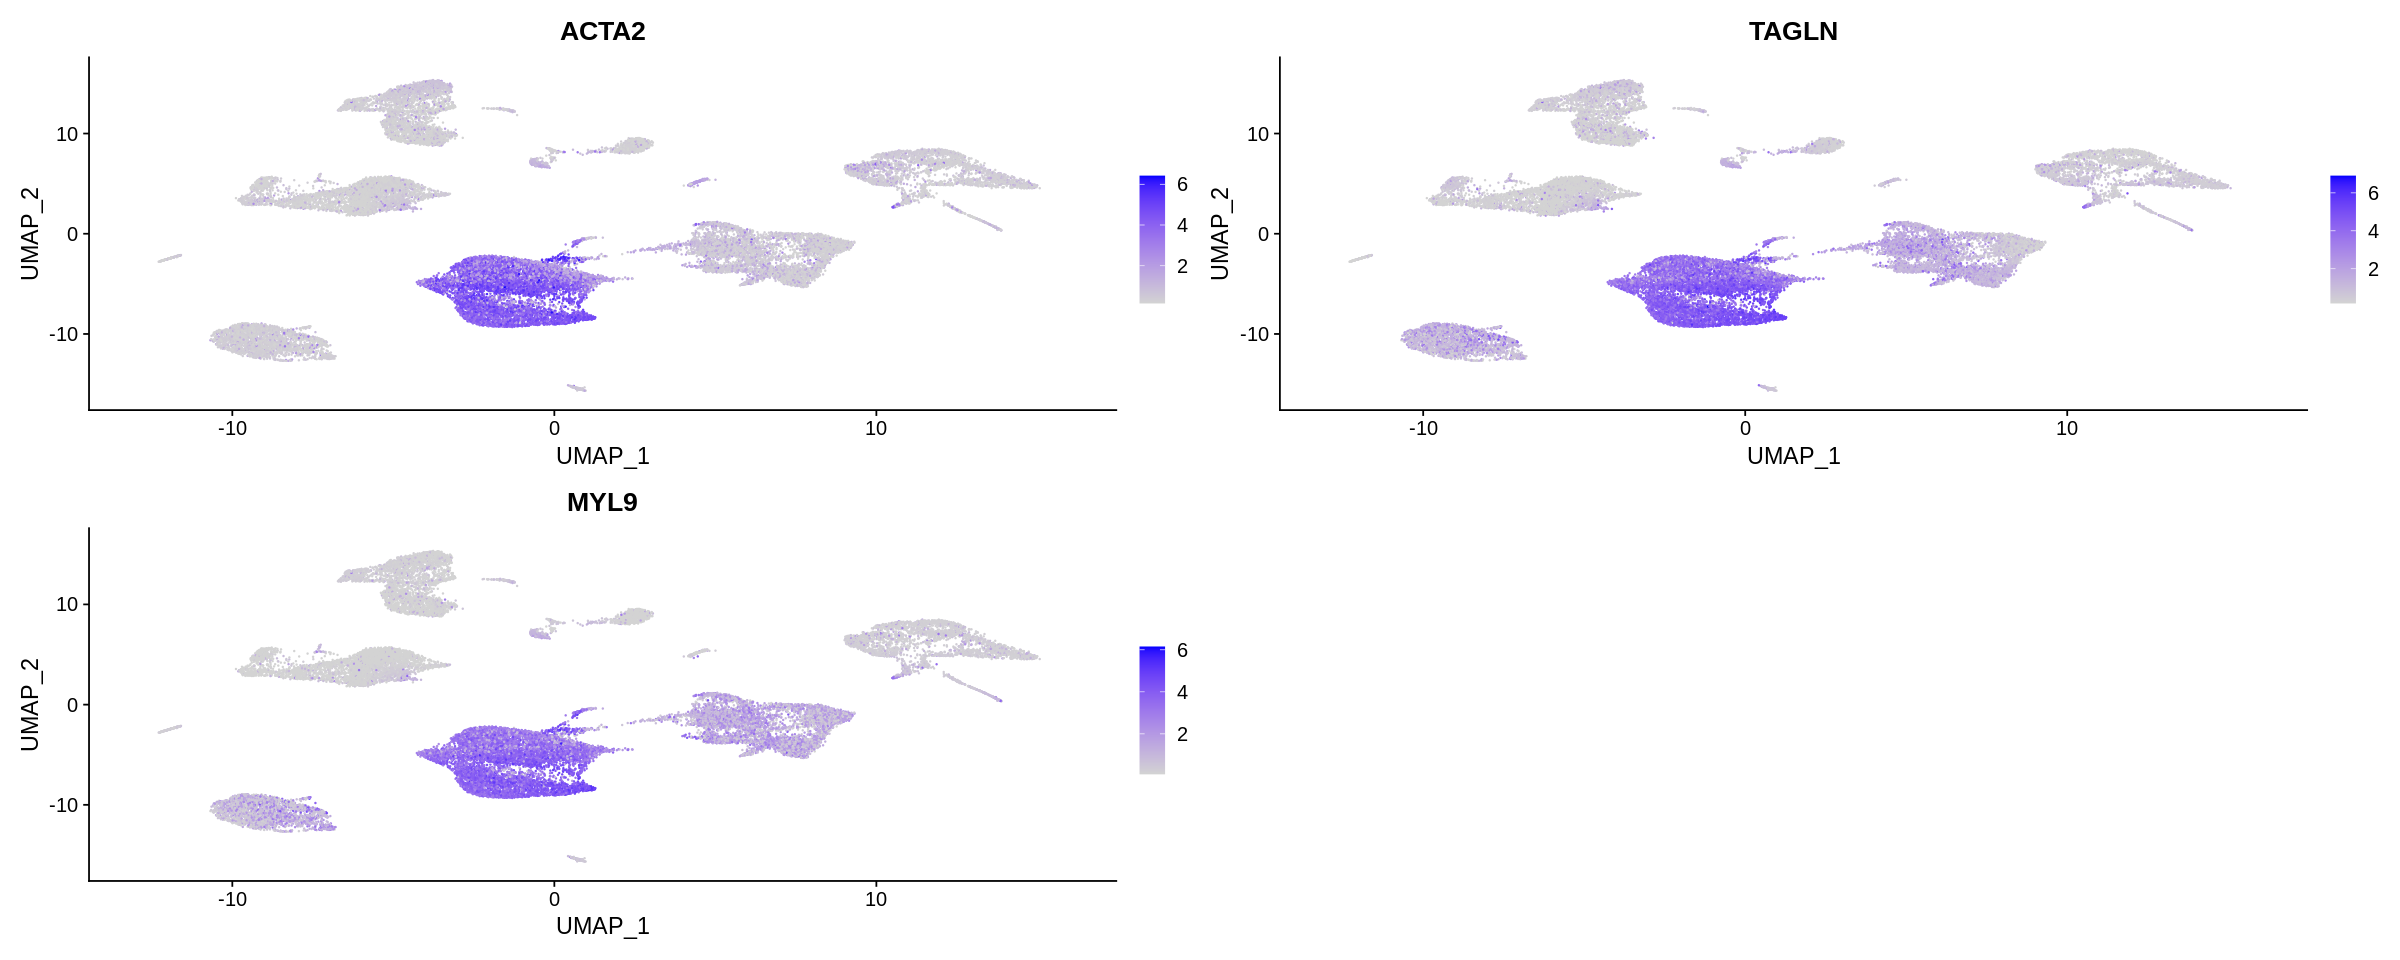

In [46]:
FeaturePlot(DFU_data.integrated, features = c('ACTA2','TAGLN','MYL9'), min.cutoff = "q9") #SMC 0

Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: IVT”


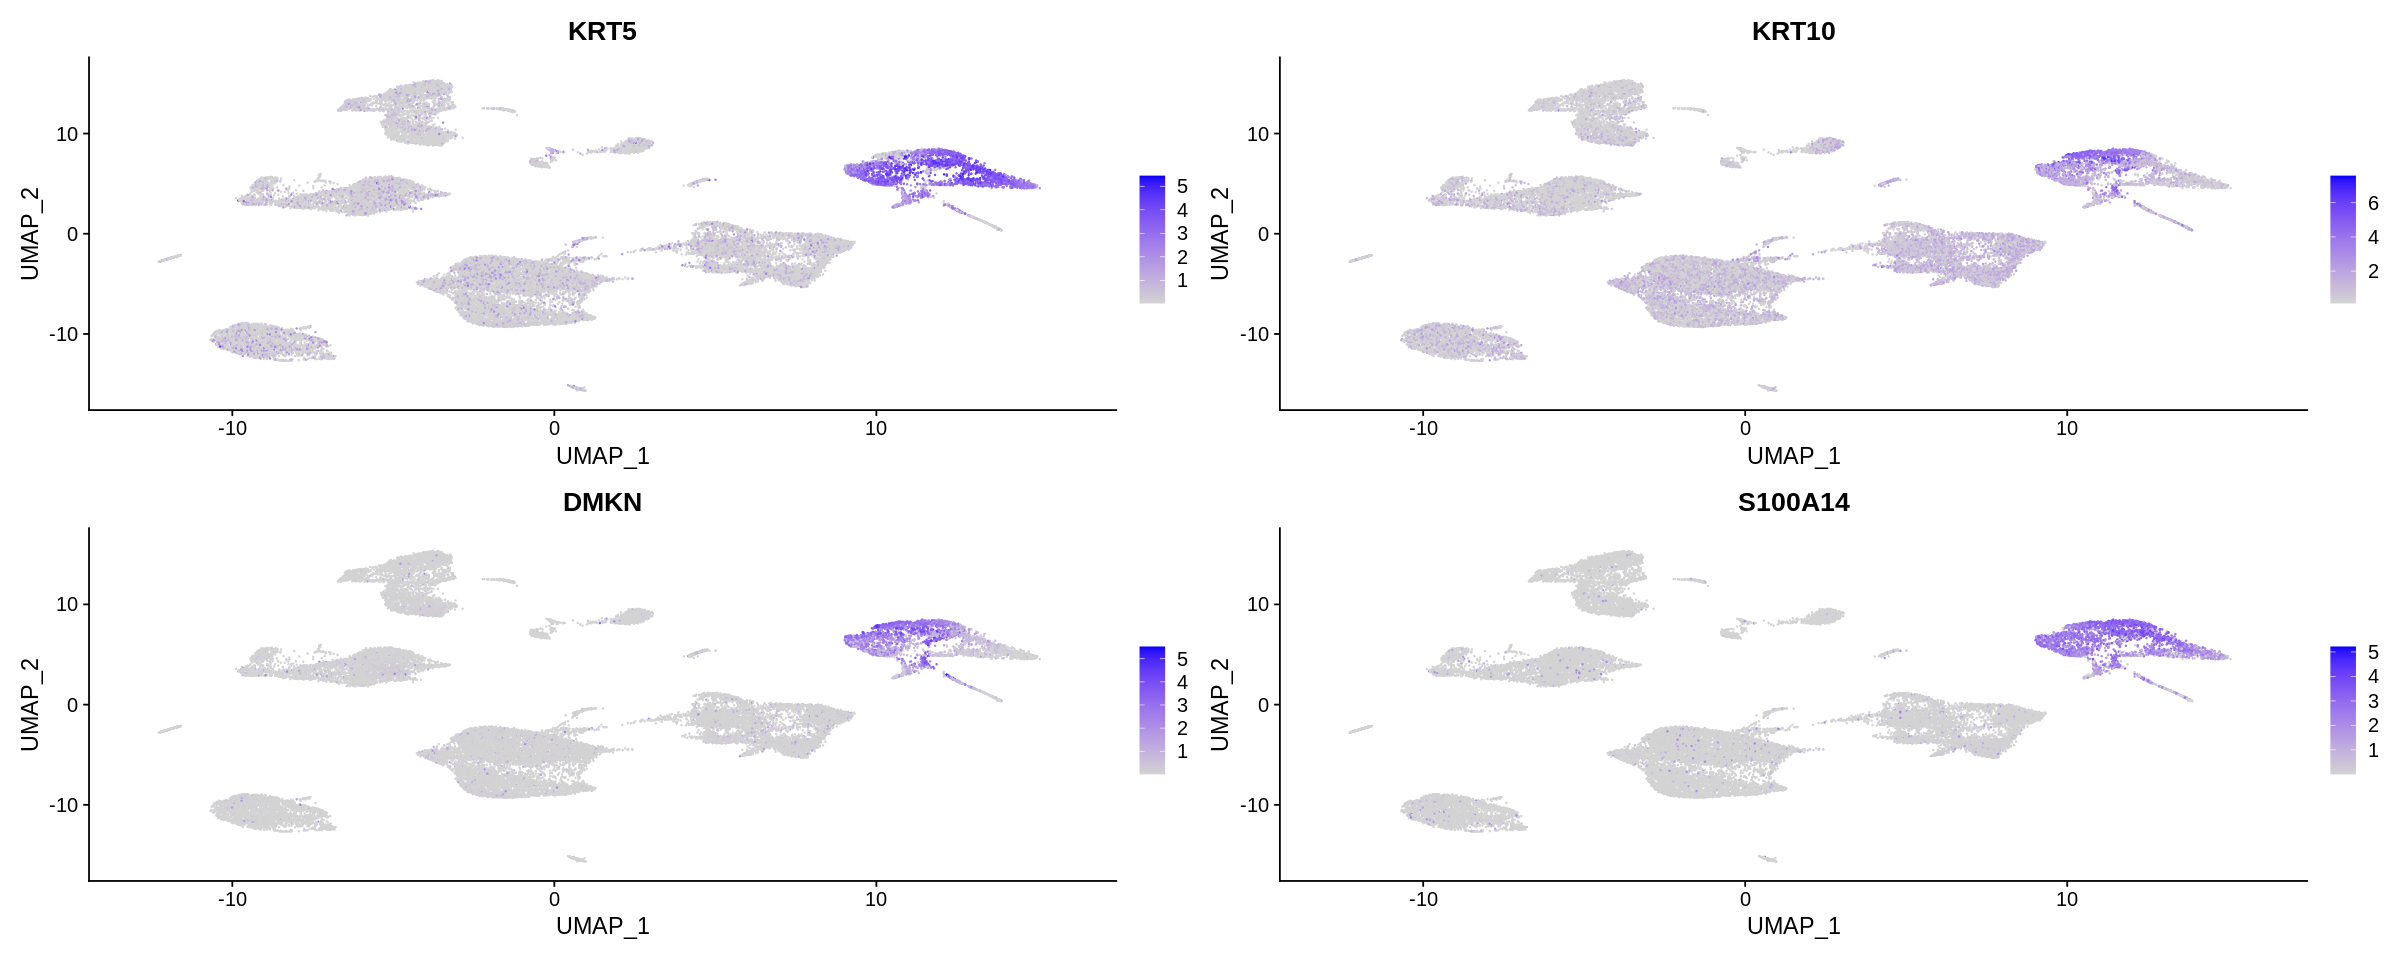

In [47]:
FeaturePlot(DFU_data.integrated, features = c('KRT5', 'KRT10','IVT','DMKN','S100A14'), min.cutoff = "q9") #Keratinocyte 4

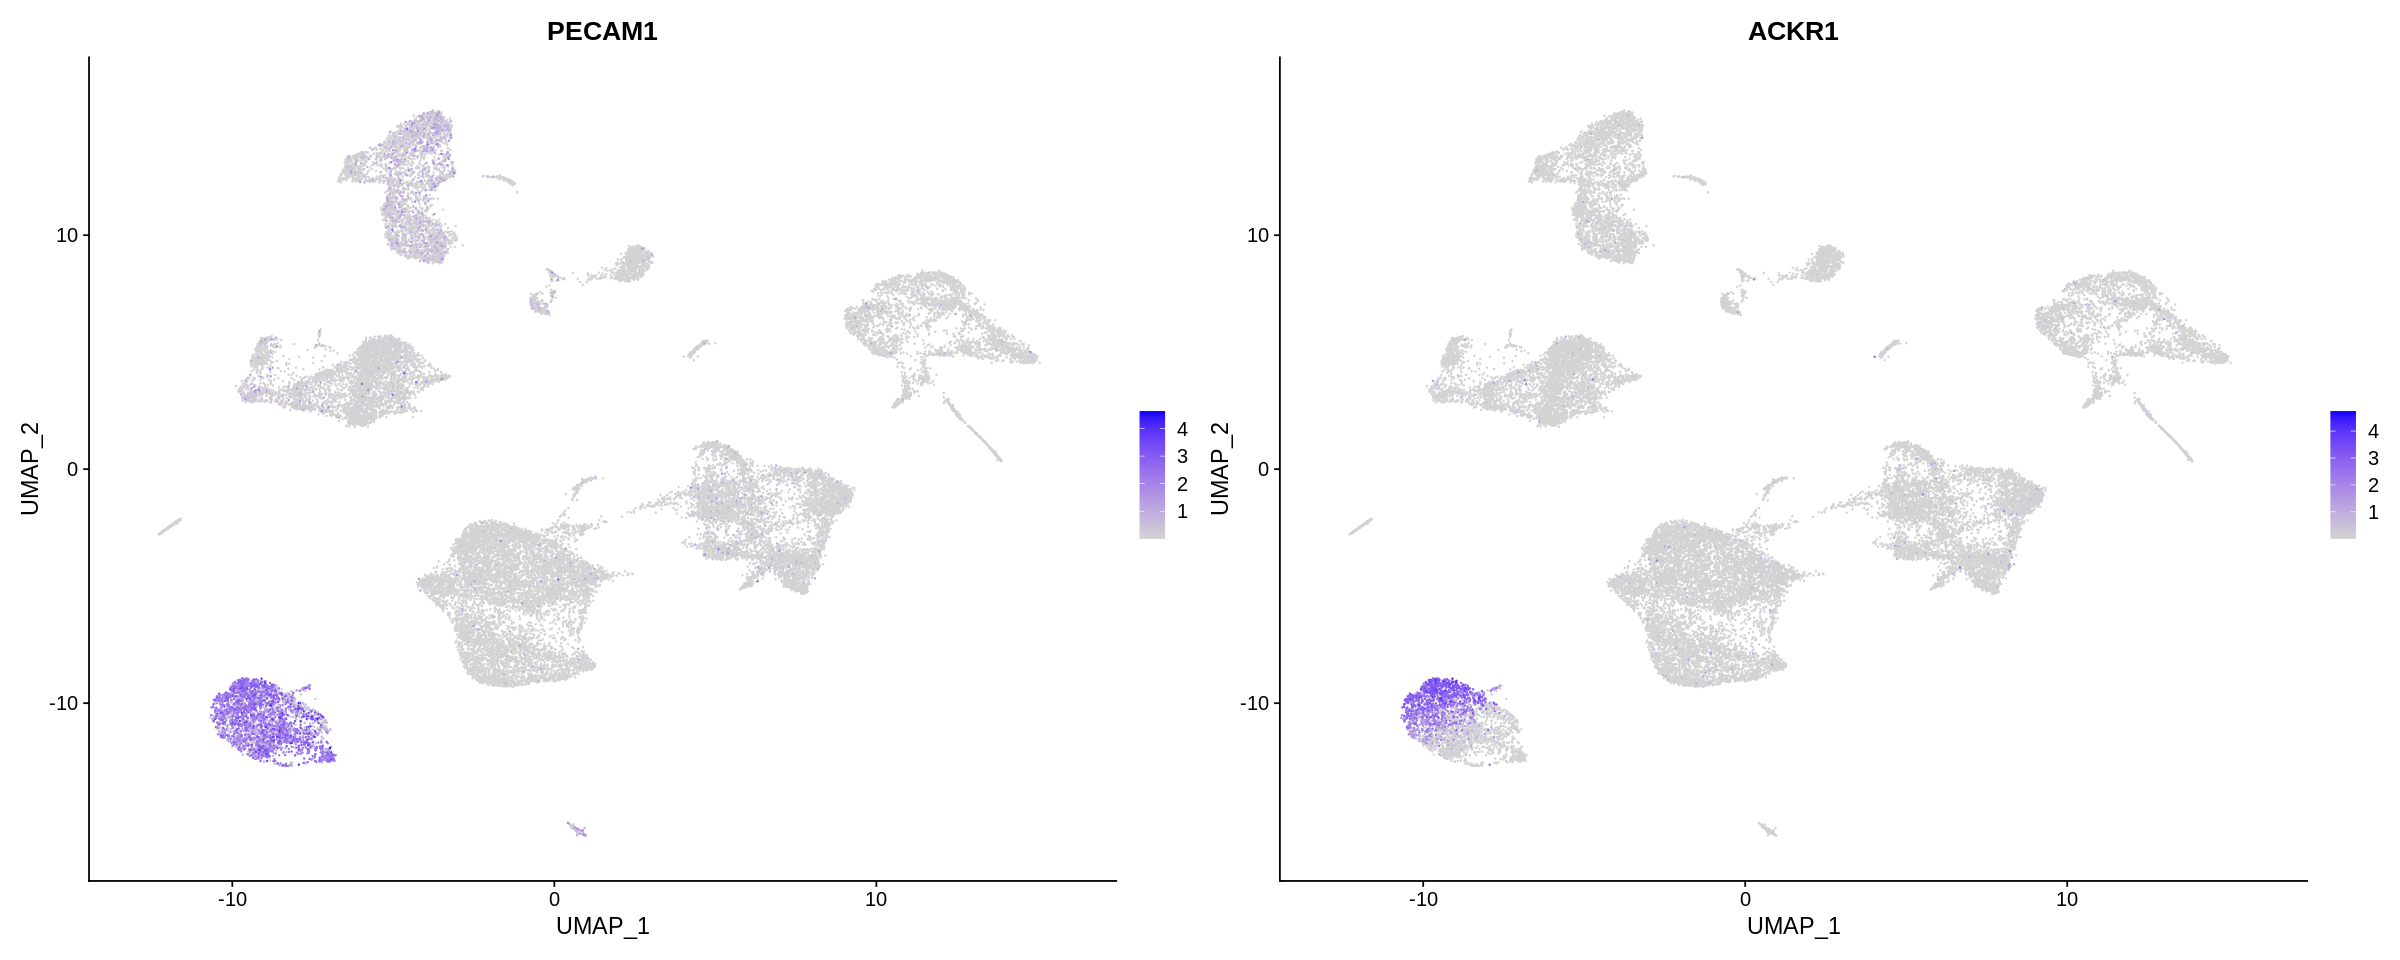

In [48]:
FeaturePlot(DFU_data.integrated, features = c('PECAM1', 'ACKR1'), min.cutoff = "q9")#epithelial 5

Warning message:
“Could not find MITF in the default search locations, found in RNA assay instead”
Warning message:
“Could not find RAB38 in the default search locations, found in RNA assay instead”


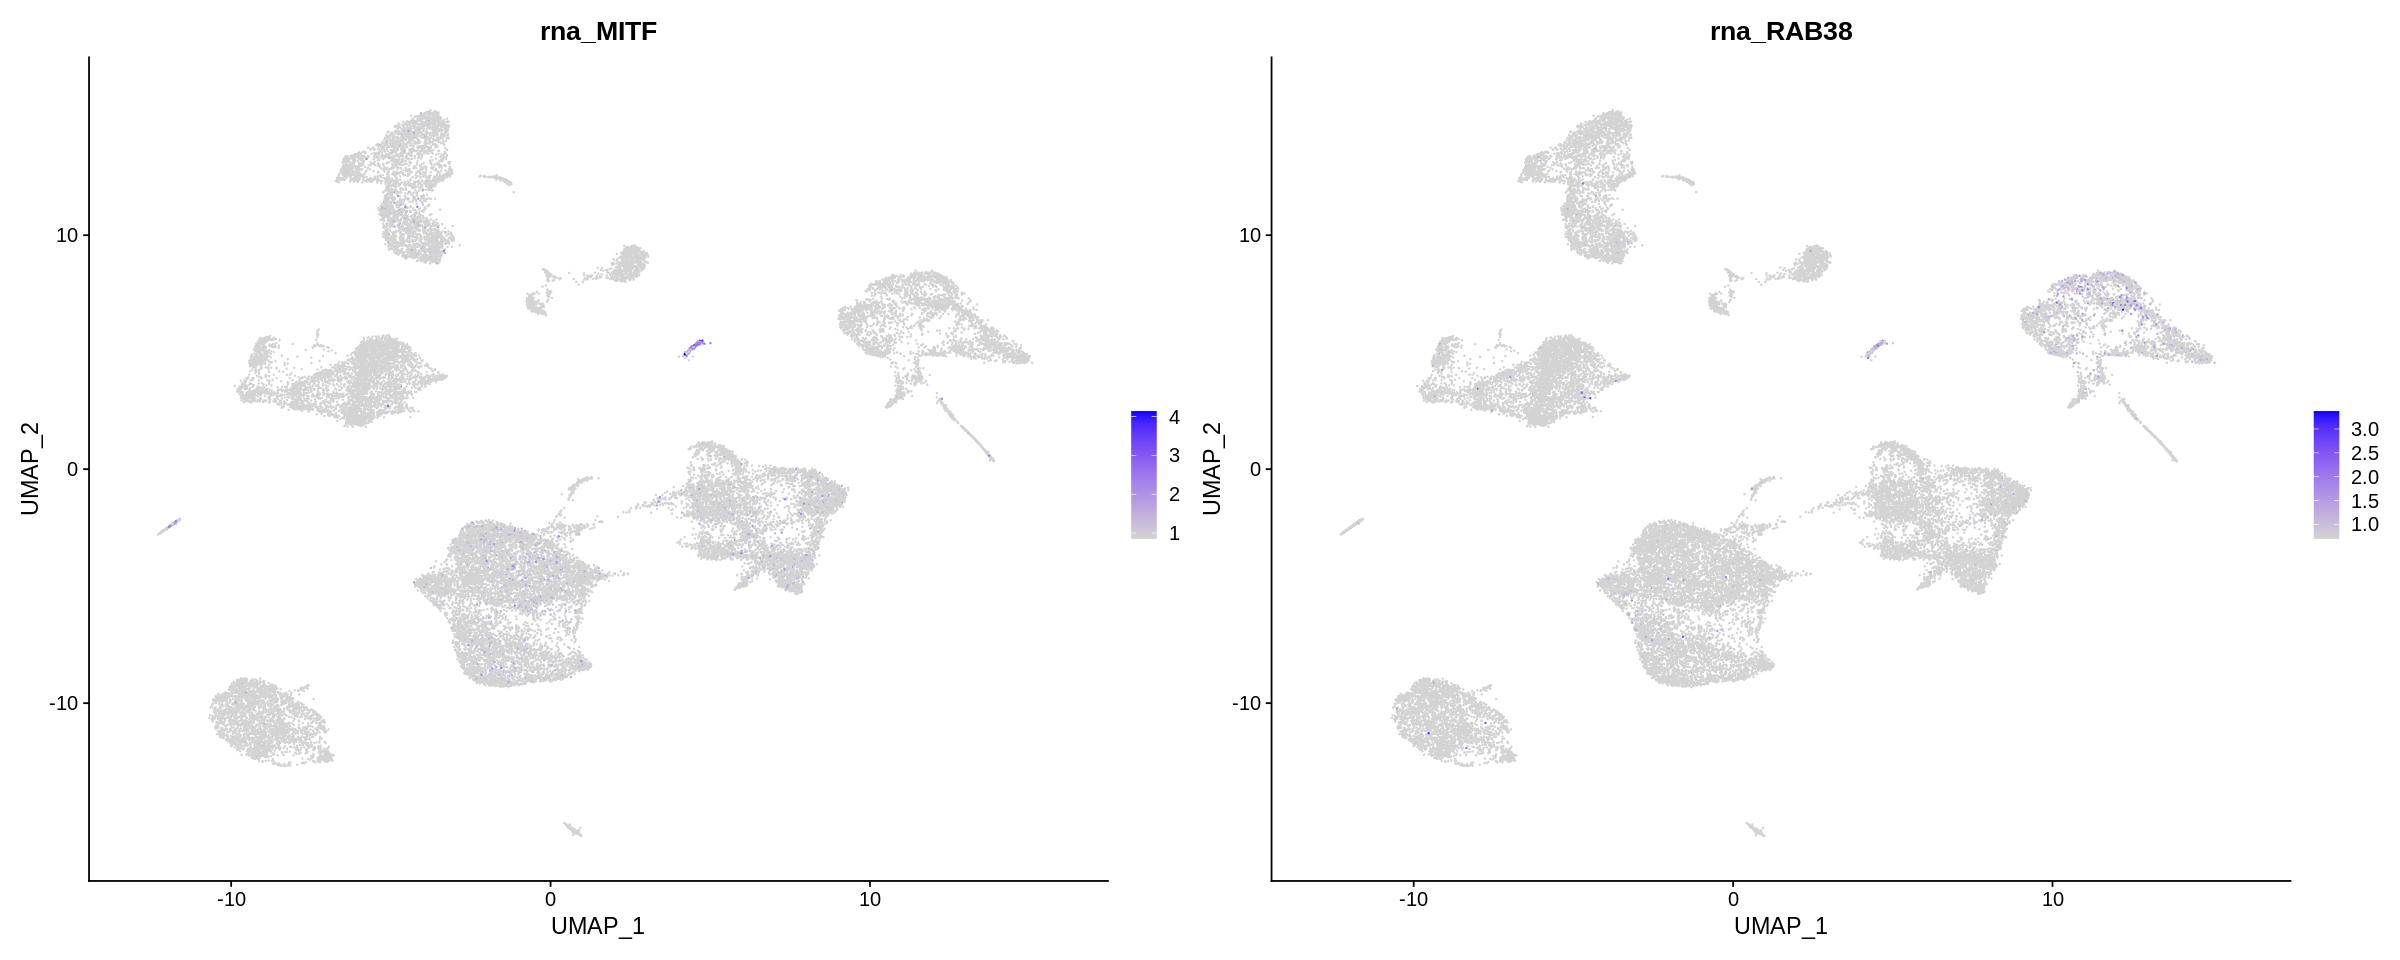

In [49]:
FeaturePlot(DFU_data.integrated, features = c('MITF','RAB38'), min.cutoff = "q9") #Melanocytes 6

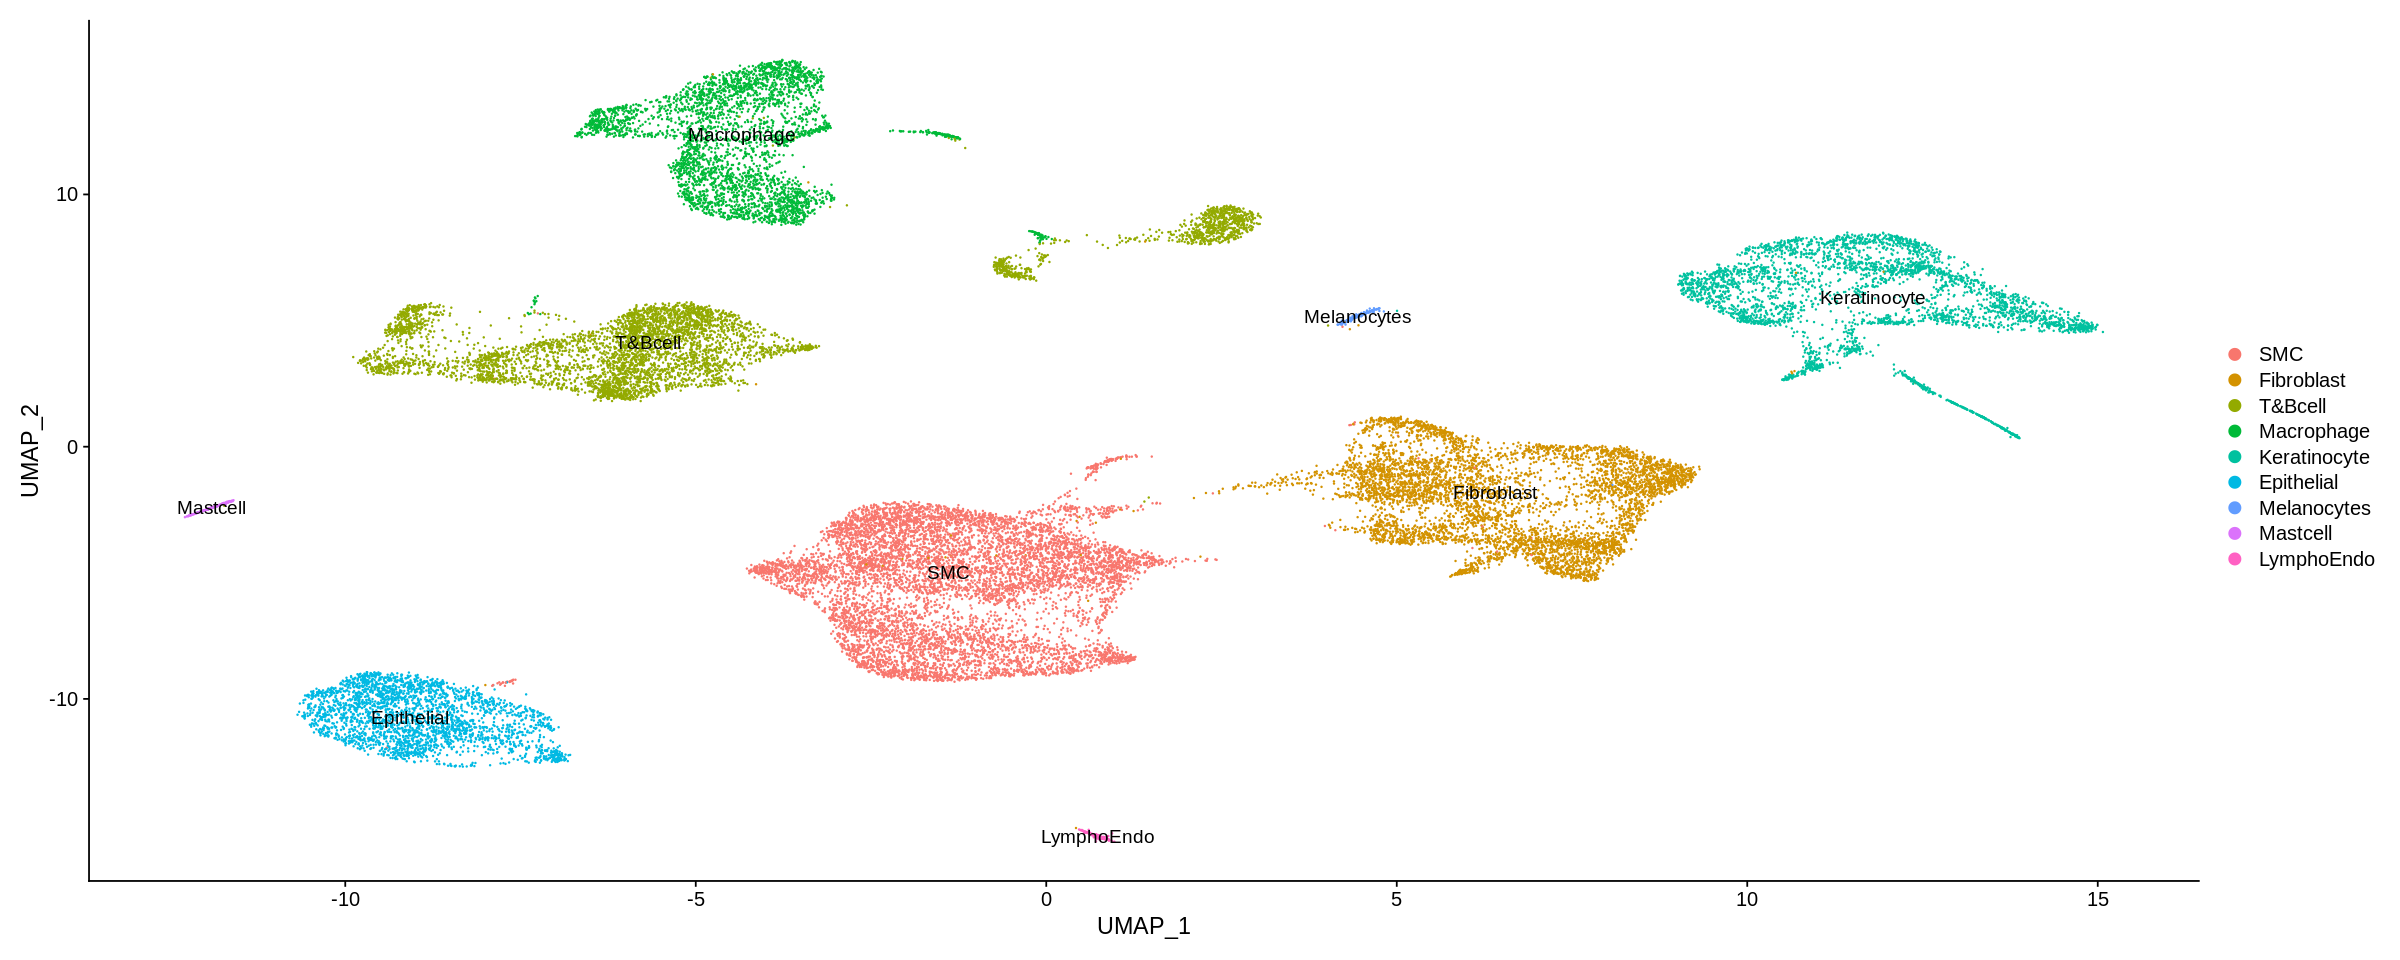

In [51]:
DFU_data.integrated_celltype <- RenameIdents(DFU_data.integrated, 
  `0` = "SMC", `1` = "Fibroblast", `2` = "T&Bcell",
  `3` = "Macrophage", `4` = "Keratinocyte",
  `5` = "Epithelial", `6` = "Melanocytes", `7` = "Mastcell", 
  `8` = "LymphoEndo")

DimPlot(DFU_data.integrated_celltype, label = TRUE)

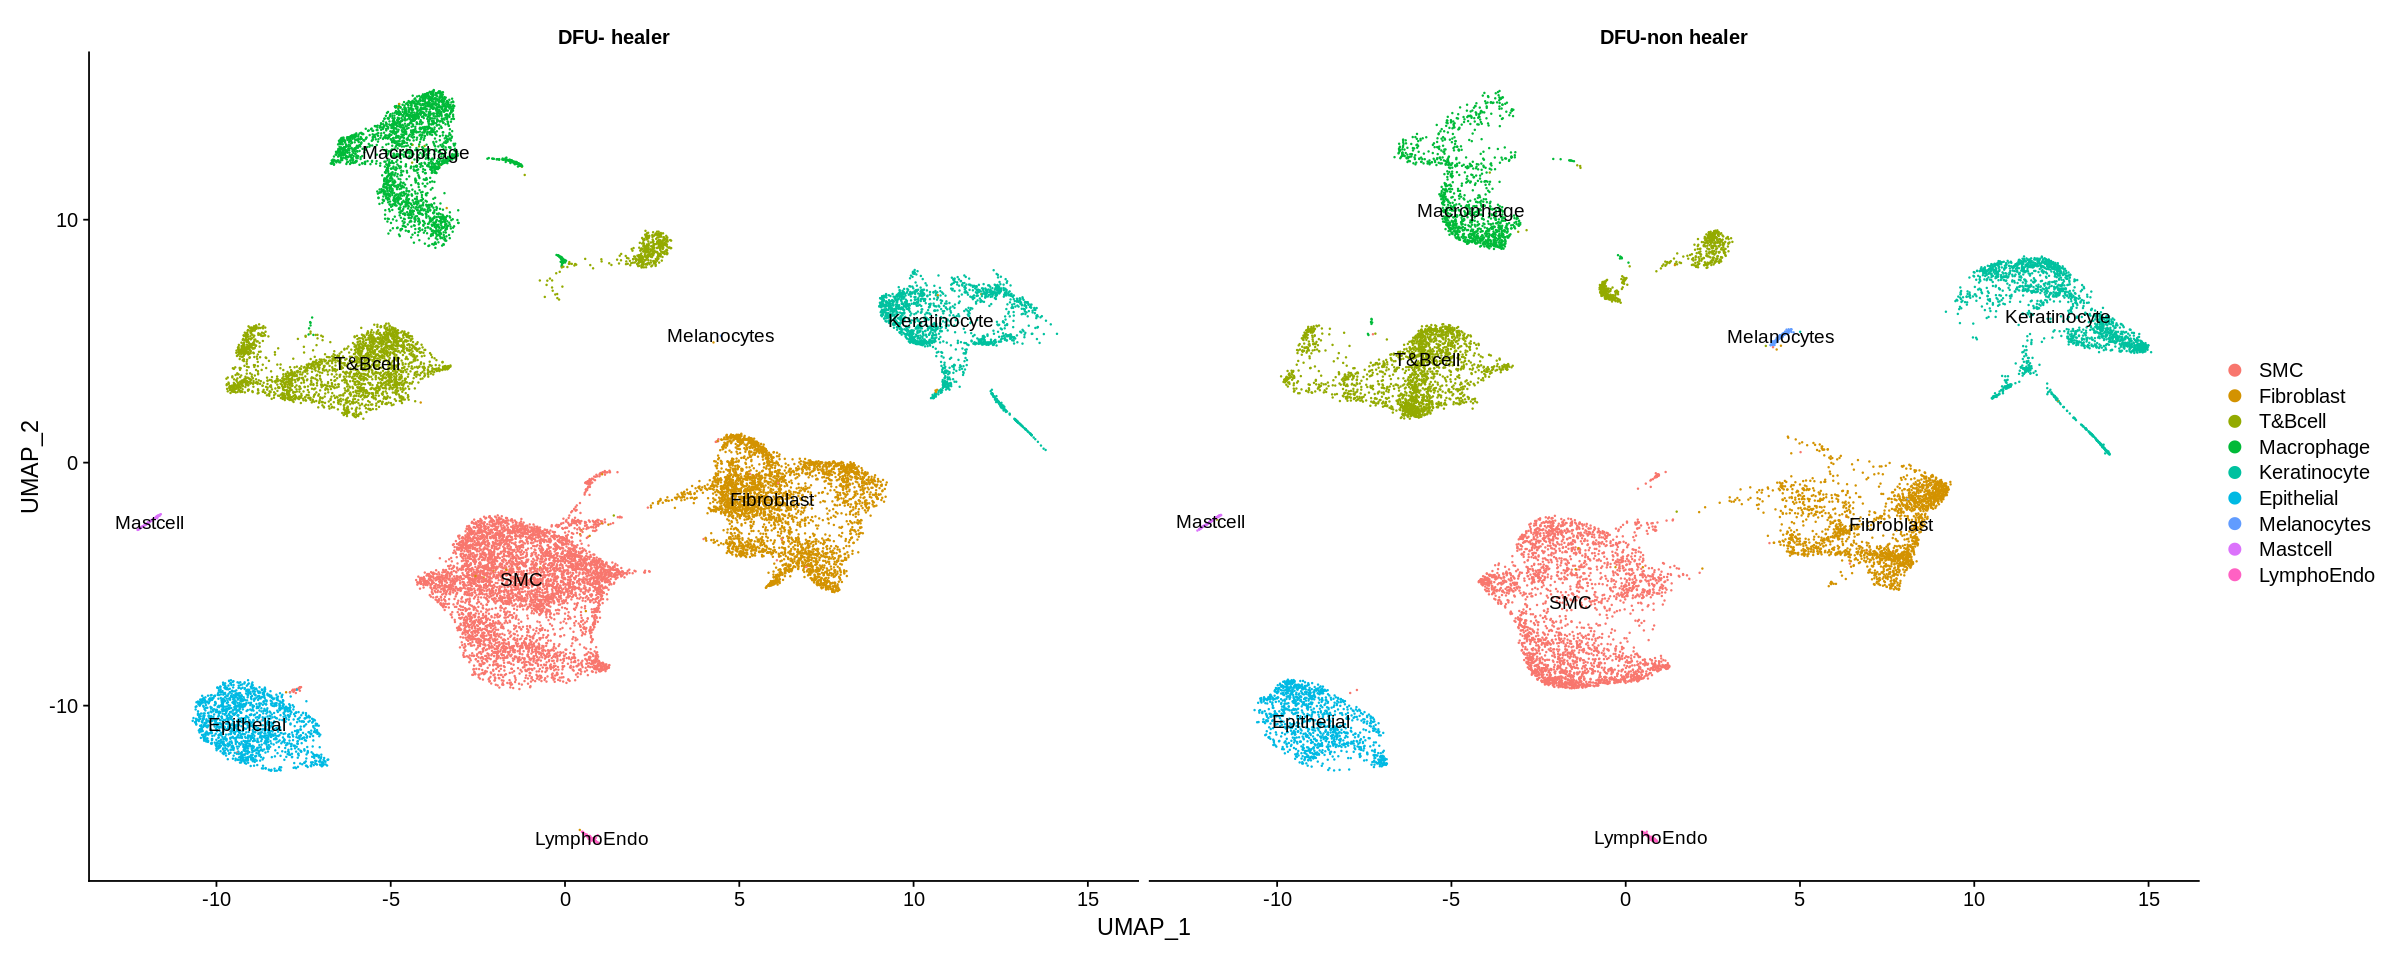

In [53]:
DimPlot(DFU_data.integrated_celltype, 
               split.by = "major_group", 
        label = TRUE) # Add labels to clusters

In [54]:
cluster_counts <- table(DFU_data.integrated_celltype$seurat_clusters)


In [55]:
print(cluster_counts)


   0    1    2    3    4    5    6    7    8 
8125 5538 5247 3540 3510 2746  216  210  187 


In [57]:
head(DFU_data.integrated_celltype)

orig.ident             nCount_RNA nFeature_RNA percent.mt
AAACCTGAGGCAGGTT_1 GSM5050523_DFU- healer 2224       1016         4.181655  
AAACCTGAGGGAACGG_1 GSM5050523_DFU- healer 3218       1460         5.189559  
AAACCTGAGGTGATTA_1 GSM5050523_DFU- healer 1785        966         4.537815  
AAACCTGAGTTAACGA_1 GSM5050523_DFU- healer 2545       1367         3.536346  
AAACCTGCATGTTGAC_1 GSM5050523_DFU- healer 2019        972         4.061417  
AAACCTGGTGACTCAT_1 GSM5050523_DFU- healer 3253       1342         2.981863  
AAACCTGGTTCAGTAC_1 GSM5050523_DFU- healer 3456       1080         3.559028  
AAACCTGTCCGCATAA_1 GSM5050523_DFU- healer 6744       2205         3.825623  
AAACCTGTCGGAAACG_1 GSM5050523_DFU- healer 3763       1510         2.870050  
AAACCTGTCGGAAATA_1 GSM5050523_DFU- healer 2294        996         4.795118  
                   major_group integrated_snn_res.0.02 seurat_clusters
AAACCTGAGGCAGGTT_1 DFU- healer 0                       0              
AAACCTGAGGGAACGG_1 DFU- healer 5                       5              
AAACCTGAGGTGATTA_1 DFU- healer 1                       1              
AAACCTGAGTTAACGA_1 DFU- healer 0                       0              
AAACCTGCATGTTGAC_1 DFU- healer 1                       1              
AAACCTGGTGACTCAT_1 DFU- healer 0                       0              
AAACCTGGTTCAGTAC_1 DFU- healer 3                       3              
AAACCTGTCCGCATAA_1 DFU- healer 1                       1              
AAACCTGTCGGAAACG_1 DFU- healer 1                       1              
AAACCTGTCGGAAATA_1 DFU- healer 5                       5

In [59]:
# Assuming your group information is stored in a column named "group"
# Replace "group" with the actual column name containing group information

group_counts <- table(DFU_data.integrated_celltype$major_group)

# Display group cell counts
print(group_counts)



   DFU- healer DFU-non healer 
         17376          11943 


In [70]:
# Assuming your Seurat object is named "seurat_obj" and contains your integrated data

# Count cells in each cluster for both groups
cluster_counts <- table(DFU_data.integrated_celltype$seurat_clusters, DFU_data.integrated_celltype$major_group)

# Display the counts and percentages
print(cluster_counts)




   
    DFU- healer DFU-non healer
  0        5288           2837
  1        3550           1988
  2        2778           2469
  3        2402           1138
  4        1624           1886
  5        1562           1184
  6           1            215
  7          85            125
  8          86            101


In [72]:
# Assuming your Seurat object is named "seurat_obj" and contains your integrated data

# Count cells in each cluster for both groups
cluster_counts <- table(DFU_data.integrated_celltype$seurat_clusters, DFU_data.integrated_celltype$orig.ident)

# Display the counts and percentages
print(cluster_counts)


   
    GSM5050523_DFU- healer GSM5050527_DFU- healer GSM5050530_DFU-non healer
  0                   1407                    798                       380
  1                    723                    456                        73
  2                    290                     94                       894
  3                     96                    406                        51
  4                     51                     42                       103
  5                    300                     96                       235
  6                      0                      0                         1
  7                     29                     10                        30
  8                     15                      2                        10
   
    GSM5050531_DFU- healer GSM5050532_DFU- healer GSM5050533_DFU-non healer
  0                    203                    249                       761
  1                    209                    659                       818
  2 

In [110]:
install.packages("writexl")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [112]:
library("writexl")


In [113]:
# Assuming cluster_counts is a table or matrix
# Convert it to a data frame
cluster_counts_df <- as.data.frame(cluster_counts)


# Specify the file path
file_path <- "/data2/ZenNa/DFU_Project/Result/cellcount.xlsx"

# Write the data frame to an Excel file
write_xlsx(cluster_counts_df, path = file_path)


In [73]:
# Calculate percentages
percentage <- prop.table(cluster_counts, margin = 2) * 100

# Display percentages
print(percentage)

   
    GSM5050523_DFU- healer GSM5050527_DFU- healer GSM5050530_DFU-non healer
  0            48.33390587            41.91176471               21.38435566
  1            24.83682583            23.94957983                4.10804727
  2             9.96221230             4.93697479               50.30951041
  3             3.29783580            21.32352941                2.87000563
  4             1.75197527             2.20588235                5.79628588
  5            10.30573686             5.04201681               13.22453573
  6             0.00000000             0.00000000                0.05627462
  7             0.99622123             0.52521008                1.68823860
  8             0.51528684             0.10504202                0.56274620
   
    GSM5050531_DFU- healer GSM5050532_DFU- healer GSM5050533_DFU-non healer
  0            18.09269162            14.83909416               21.43058293
  1            18.62745098            39.27294398               23.03576457
  2 

In [74]:
library(ggplot2)

In [79]:
percentage_df <- as.data.frame(percentage)

In [82]:
percentage_df

Var1 Var2                      Freq       
1   0    GSM5050523_DFU- healer    48.33390587
2   1    GSM5050523_DFU- healer    24.83682583
3   2    GSM5050523_DFU- healer     9.96221230
4   3    GSM5050523_DFU- healer     3.29783580
5   4    GSM5050523_DFU- healer     1.75197527
6   5    GSM5050523_DFU- healer    10.30573686
7   6    GSM5050523_DFU- healer     0.00000000
8   7    GSM5050523_DFU- healer     0.99622123
9   8    GSM5050523_DFU- healer     0.51528684
10  0    GSM5050527_DFU- healer    41.91176471
11  1    GSM5050527_DFU- healer    23.94957983
12  2    GSM5050527_DFU- healer     4.93697479
13  3    GSM5050527_DFU- healer    21.32352941
14  4    GSM5050527_DFU- healer     2.20588235
15  5    GSM5050527_DFU- healer     5.04201681
16  6    GSM5050527_DFU- healer     0.00000000
17  7    GSM5050527_DFU- healer     0.52521008
18  8    GSM5050527_DFU- healer     0.10504202
19  0    GSM5050530_DFU-non healer 21.38435566
20  1    GSM5050530_DFU-non healer  4.10804727
21  2    GSM5050530_DFU-non healer 50.30951041
22  3    GSM5050530_DFU-non healer  2.87000563
23  4    GSM5050530_DFU-non healer  5.79628588
24  5    GSM5050530_DFU-non healer 13.22453573
25  6    GSM5050530_DFU-non healer  0.05627462
26  7    GSM5050530_DFU-non healer  1.68823860
27  8    GSM5050530_DFU-non healer  0.56274620
28  0    GSM5050531_DFU- healer    18.09269162
29  1    GSM5050531_DFU- healer    18.62745098
30  2    GSM5050531_DFU- healer    29.76827094
⋮   ⋮    ⋮                         ⋮          
97  6    GSM5050563_DFU-non healer  0.0000000 
98  7    GSM5050563_DFU-non healer  0.1467351 
99  8    GSM5050563_DFU-non healer  0.1467351 
100 0    GSM5050566_DFU- healer    13.3674215 
101 1    GSM5050566_DFU- healer     3.7253470 
102 2    GSM5050566_DFU- healer    37.9839299 
103 3    GSM5050566_DFU- healer     2.6296567 
104 4    GSM5050566_DFU- healer    21.7677137 
105 5    GSM5050566_DFU- healer    20.2337473 
106 6    GSM5050566_DFU- healer     0.0000000 
107 7    GSM5050566_DFU- healer     0.1460920 
108 8    GSM5050566_DFU- healer     0.1460920 
109 0    GSM5050569_DFU- healer    16.7487685 
110 1    GSM5050569_DFU- healer    39.6278051 
111 2    GSM5050569_DFU- healer     6.0207991 
112 3    GSM5050569_DFU- healer     6.5134100 
113 4    GSM5050569_DFU- healer    15.5993432 
114 5    GSM5050569_DFU- healer    14.7235906 
115 6    GSM5050569_DFU- healer     0.0000000 
116 7    GSM5050569_DFU- healer     0.1642036 
117 8    GSM5050569_DFU- healer     0.6020799 
118 0    GSM5050573_DFU- healer    25.3582284 
119 1    GSM5050573_DFU- healer     6.7303517 
120 2    GSM5050573_DFU- healer    22.3187147 
121 3    GSM5050573_DFU- healer     3.5171515 
122 4    GSM5050573_DFU- healer    35.0412505 
123 5    GSM5050573_DFU- healer     6.2092922 
124 6    GSM5050573_DFU- healer     0.0000000 
125 7    GSM5050573_DFU- healer     0.3907946 
126 8    GSM5050573_DFU- healer     0.4342162